# 1: Import Libraries and Load Dataset
In this section, we import all the Python libraries dealing with data manipulation, numerical manipulations, and plotting.
We first import the dataset to a pandas DataFrame and proceed to clean - drop unnecessary columns.

In [21]:
# Import required libraries for data processing, visualization, and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = 'final.csv'   # File path to the dataset
data = pd.read_csv(data_path)

# Drop columns that are unnecessary or specified
columns_to_drop = ['GPE', 'HSX', 'HMSO', 'BLND', 'SGRO', 'SHC']
data = data.drop(columns=columns_to_drop, errors='ignore')  # Drop specified columns safely
print(f"Dropped columns: {columns_to_drop}")


Dropped columns: ['GPE', 'HSX', 'HMSO', 'BLND', 'SGRO', 'SHC']


# 2: Handle Missing Values and Format the Date Column

1. We drop the columns having more than 50% missing values.
2. We then convert the 'date' column to a proper datetime format.
3. Rows containing invalid dates are removed.
4. The remaining missing values are filled using a forward-fill approach.
5. A summary of the cleaned dataset is shown.

In [22]:
# Drop columns with more than 50% null values
threshold = 0.5 * len(data)  # Threshold for null values (50% of total rows)
data = data.loc[:, data.isnull().sum() < threshold]  # Retain columns below the threshold

# Display remaining columns
print("Remaining columns after preprocessing:", data.columns)

# Convert the 'date' column to a proper datetime format if it exists
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')  # Convert to datetime
    print("Date column successfully formatted.")

# Do not include rows where the "date" column is not correct.

data = data.dropna(subset=['date'])

# Reset index after preprocessing
data = data.reset_index(drop=True)
print("Dataset after preprocessing:")
print(data.head())

# Check for missing values in the dataset
print("Missing values after preprocessing:\n", data.isnull().sum())

# Fill remaining missing values using forward fill
data = data.fillna(method='ffill')

# Display basic statistics about the dataset
print("Dataset Summary:\n", data.describe())


Remaining columns after preprocessing: Index(['date', 'BARC', 'HSBA', 'LLOY', 'NWG', 'STAN', 'AV', 'LGEN', 'PRU',
       'DLN', 'LAND'],
      dtype='object')
Date column successfully formatted.
Dataset after preprocessing:
        date        BARC        HSBA        LLOY          NWG        STAN  \
0 2000-03-01  411.528290  752.048828  503.139404  3383.091553  771.339905   
1 2000-04-01  385.663391  716.755676  471.632294  3290.657227  750.069885   
2 2000-05-01  376.425995  690.176880  470.982605  3321.468750  720.372070   
3 2000-06-01  362.338898  667.519592  455.391510  3327.631104  671.812195   
4 2000-07-01  354.256103  672.748230  439.475494  3349.198975  677.430725   

            AV    LGEN         PRU    DLN        LAND  
0  1313.157837  168.50  898.032410  542.5  657.851013  
1  1226.315674  166.00  911.809021  542.5  638.892822  
2  1189.473633  162.00  864.028625  540.0  653.585388  
3  1178.947266  160.25  870.399414  540.0  653.585388  
4  1205.263062  161.25  880.75177

# 3: Exploratory Data Analysis (EDA)

1. It analyzes and gives a better understanding of the structure and relationships in the data, usually through the basic descriptive statistics summary statistics include mean, standard deviation, minimum, and maximum values.

2. **Correlation Matrix:** Shows the linear relationships between numerical columns.
3. **Heatmap Visualization:** Visualize the correlation matrix using a heatmap for better understanding.


In [23]:
# Display basic descriptive statistics for all numerical columns
print("Basic Descriptive Statistics:")
print(data.describe())

# Correlation matrix to analyze relationships between numeric columns
correlation_matrix = data.corr()  # Compute pairwise correlation of columns

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))  # Choose a figure size to improve viewability.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') # Display annotated heatmap
plt.title("Correlation Matrix")
plt.show()


Basic Descriptive Statistics:
                                date         BARC         HSBA         LLOY  \
count                           2493  2493.000000  2493.000000  2493.000000   
mean   2012-04-28 03:15:48.736462080   303.701169   644.847920   161.227222   
min              2000-01-02 00:00:00    56.717899   304.131012    24.000000   
25%              2006-02-02 00:00:00   175.720001   578.633179    51.759998   
50%              2012-04-12 00:00:00   254.584000   653.599976    68.940002   
75%              2018-07-12 00:00:00   432.543488   728.520081   296.069397   
max              2024-12-09 00:00:00   714.054688   926.335877   530.748718   
std                              NaN   153.740148   120.008325   147.700522   

               NWG         STAN           AV         LGEN          PRU  \
count  2493.000000  2493.000000  2493.000000  2493.000000  2493.000000   
mean   1921.579384   897.612153   667.000001   177.519664   827.372783   
min     109.576897   354.899994   21

#  4: Perform augmented Dickey-Fuller (ADF) Test for stationarity
1. This step checks if the data of the time series is stationary or not.
2. Stationarity is a pre-requisite for many time series models such as ARIMA and VAR.
3. We check whether each column is stationary by using the Augmented Dickey-Fuller (ADF) Test:

4. By the **null hypothesis (H0)**, the series contains a unit root—that is, it is non-stationary.
5. **H1**: The series is stationary. It does not have a unit root.

The test outputs:

**ADF Statistic**: The test statistic value.
Therefore, when the **p-value** is less than 0.05, we can reject the null hypothesis and deduce that this series is a stationary one.

In [24]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, column_name):
    """
    Perform the Augmented Dickey-Fuller (ADF) test to check stationarity of a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - column_name (str): Name of the column being tested.

    Returns:
    - Prints the ADF Statistic and p-value for interpretation.
    """
    print(f"\nPerforming ADF Test for column: {column_name}")
    try:
        # Perform the ADF test after dropping NaN values
        result = adfuller(series.dropna())
        
        # Extract and print results
        print(f"ADF Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        
        # Check if the column is stationary based on the p-value
        if result[1] <= 0.05:
            print(f"Column '{column_name}' is Stationary (p-value <= 0.05)")
        else:
            print(f"Column '{column_name}' is Not Stationary (p-value > 0.05)")
    except Exception as e:
        print(f"Error in ADF Test for column '{column_name}': {e}")

# Apply ADF test to all numeric columns except 'date'
for col in data.columns:
    if col != 'date':  # Exclude the 'date' column
        adf_test(data[col], col)



Performing ADF Test for column: BARC
ADF Statistic: -1.4008513461034815
p-value: 0.5818679045108142
Column 'BARC' is Not Stationary (p-value > 0.05)

Performing ADF Test for column: HSBA
ADF Statistic: -3.0576131870834318
p-value: 0.029853212615670647
Column 'HSBA' is Stationary (p-value <= 0.05)

Performing ADF Test for column: LLOY
ADF Statistic: -1.8848900847792973
p-value: 0.3392023353356921
Column 'LLOY' is Not Stationary (p-value > 0.05)

Performing ADF Test for column: NWG
ADF Statistic: -0.7744184196391203
p-value: 0.8265212247684512
Column 'NWG' is Not Stationary (p-value > 0.05)

Performing ADF Test for column: STAN
ADF Statistic: -1.9720072611204897
p-value: 0.2989801762260528
Column 'STAN' is Not Stationary (p-value > 0.05)

Performing ADF Test for column: AV
ADF Statistic: -1.9749309911420152
p-value: 0.297671985059675
Column 'AV' is Not Stationary (p-value > 0.05)

Performing ADF Test for column: LGEN
ADF Statistic: -1.1787910136949487
p-value: 0.6826521016939242
Column 

#  5: Calculate Log Returns for Non-Stationary Columns

In this step, we calculate the **log returns** for columns that were identified as **non-stationary** during the ADF test.  
Log returns are often used in financial time series to stabilize variance and achieve stationarity.  

The formula for **log returns** is:
\[
\text{Log Return} = 100 \times \left( \log(P_t) - \log(P_{t-1}) \right)
\]
Where:
- \( P_t \): The price (or value) at time \( t \).
- \( P_{t-1} \): The price (or value) at time \( t-1 \).

After calculating log returns:
1. Drop any **NaN values** caused by the calculation.  
2. Re-run the **ADF Test** on the log return columns to confirm stationarity.


In [25]:
# List of non-stationary columns identified earlier
non_stationary_columns = ['BARC', 'LLOY', 'NWG', 'STAN', 'AV', 'LGEN', 'PRU', 'DLN', 'LAND']

# Calculate log returns for non-stationary columns
for col in non_stationary_columns:
    # Log return formula: 100 * (log(current value) - log(previous value))
    data[f'{col}_log_return'] = 100 * (np.log(data[col]) - np.log(data[col].shift(1)))

# Drop NaN values caused by the first differencing (log return calculation)
data = data.dropna().reset_index(drop=True)

# Print a preview of the dataset after calculating log returns
print("Dataset with Log Return Columns:")
print(data.head())

# Perform ADF test again to confirm stationarity of log return columns
print("\nPerforming ADF Test on Log Return Columns:\n")
for col in non_stationary_columns:
    log_return_col = f'{col}_log_return'
    adf_test(data[log_return_col], log_return_col)


Dataset with Log Return Columns:
        date        BARC        HSBA        LLOY          NWG        STAN  \
0 2000-04-01  385.663391  716.755676  471.632294  3290.657227  750.069885   
1 2000-05-01  376.425995  690.176880  470.982605  3321.468750  720.372070   
2 2000-06-01  362.338898  667.519592  455.391510  3327.631104  671.812195   
3 2000-07-01  354.256103  672.748230  439.475494  3349.198975  677.430725   
4 2000-10-01  359.105804  675.798218  451.818512  3376.929199  692.680908   

            AV    LGEN         PRU    DLN        LAND  BARC_log_return  \
0  1226.315674  166.00  911.809021  542.5  638.892822        -6.491282   
1  1189.473633  162.00  864.028625  540.0  653.585388        -2.424348   
2  1178.947266  160.25  870.399414  540.0  653.585388        -3.814151   
3  1205.263062  161.25  880.751770  537.5  656.429199        -2.255985   
4  1213.157837  160.00  910.216370  537.5  656.429199         1.359696   

   LLOY_log_return  NWG_log_return  STAN_log_return  AV_log

#  6: Split Data into Train and Test Sets

In this step, we split the log return columns into **training** and **testing** sets.  
- **Training Set**: Used to train the models. It contains 90% of the data.  
- **Testing Set**: Used to evaluate the models' performance. It contains the remaining 10% of the data.

This split ensures that models are evaluated on unseen data, helping us measure their predictive performance.


In [26]:
# Identify log return columns for modeling
log_return_columns = [col for col in data.columns if 'log_return' in col]

# here, we have to split training (90%), testing (10%),it will sets from the data.
train_size = int(len(data) * 0.9)   
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Print the sizes of the train and test sets
print("Train-Test Split Completed:")
print(f"Training set size: {len(train)} rows")
print(f"Testing set size: {len(test)} rows")

# Print a preview of the train and test sets
print("\nTraining Set Preview:")
print(train.head())
print("\nTesting Set Preview:")
print(test.head())


Train-Test Split Completed:
Training set size: 2242 rows
Testing set size: 250 rows

Training Set Preview:
        date        BARC        HSBA        LLOY          NWG        STAN  \
0 2000-04-01  385.663391  716.755676  471.632294  3290.657227  750.069885   
1 2000-05-01  376.425995  690.176880  470.982605  3321.468750  720.372070   
2 2000-06-01  362.338898  667.519592  455.391510  3327.631104  671.812195   
3 2000-07-01  354.256103  672.748230  439.475494  3349.198975  677.430725   
4 2000-10-01  359.105804  675.798218  451.818512  3376.929199  692.680908   

            AV    LGEN         PRU    DLN        LAND  BARC_log_return  \
0  1226.315674  166.00  911.809021  542.5  638.892822        -6.491282   
1  1189.473633  162.00  864.028625  540.0  653.585388        -2.424348   
2  1178.947266  160.25  870.399414  540.0  653.585388        -3.814151   
3  1205.263062  161.25  880.751770  537.5  656.429199        -2.255985   
4  1213.157837  160.00  910.216370  537.5  656.429199       

# 7: Apply the VAR (Vector AutoRegression) Model.
Here we forecast the log returns of all selected columns simultaneously using the VAR (Vector AutoRegression) model.
A multivariate time series model, the VAR captures the linear relationships among multiple time series.

The system is as follows:

1. Fitting of the VAR model on training data.
2. Predicting the log returns of the test data.
3. Performance evaluation can be done for each column, by calculating MSE (Mean Squared Error) and RMSE (Root Mean Squared Error).
4. Seeing, for every column, the actual against expected values.

5. Performing residual diagnostics using the Ljung-Box test to check for autocorrelation in the residuals.
6. Organizing and displaying RMSE results in a summary table for easy analysis.

Applying VAR Model...
['BARC_log_return', 'LLOY_log_return', 'NWG_log_return', 'STAN_log_return', 'AV_log_return', 'LGEN_log_return', 'PRU_log_return', 'DLN_log_return', 'LAND_log_return']
[[-0.58152941 -0.44936069 -0.55389155 ...  0.07184183  0.00743111
  -0.28875415]
 [-0.06390737 -0.13970331 -0.13709373 ... -0.05847094  0.05514926
  -0.00969206]
 [-0.04744411 -0.10589821 -0.12536511 ...  0.01549087  0.07713885
   0.00619277]
 ...
 [-0.04456566 -0.10477091 -0.11937439 ...  0.00904287  0.07907117
   0.00857107]
 [-0.04456566 -0.10477091 -0.11937439 ...  0.00904287  0.07907117
   0.00857107]
 [-0.04456566 -0.10477091 -0.11937439 ...  0.00904287  0.07907117
   0.00857107]]
      BARC_log_return  LLOY_log_return  NWG_log_return  STAN_log_return  \
2242        -0.581529        -0.449361       -0.553892        -0.141047   
2243        -0.063907        -0.139703       -0.137094        -0.047353   
2244        -0.047444        -0.105898       -0.125365        -0.015768   
2245        -0.0451

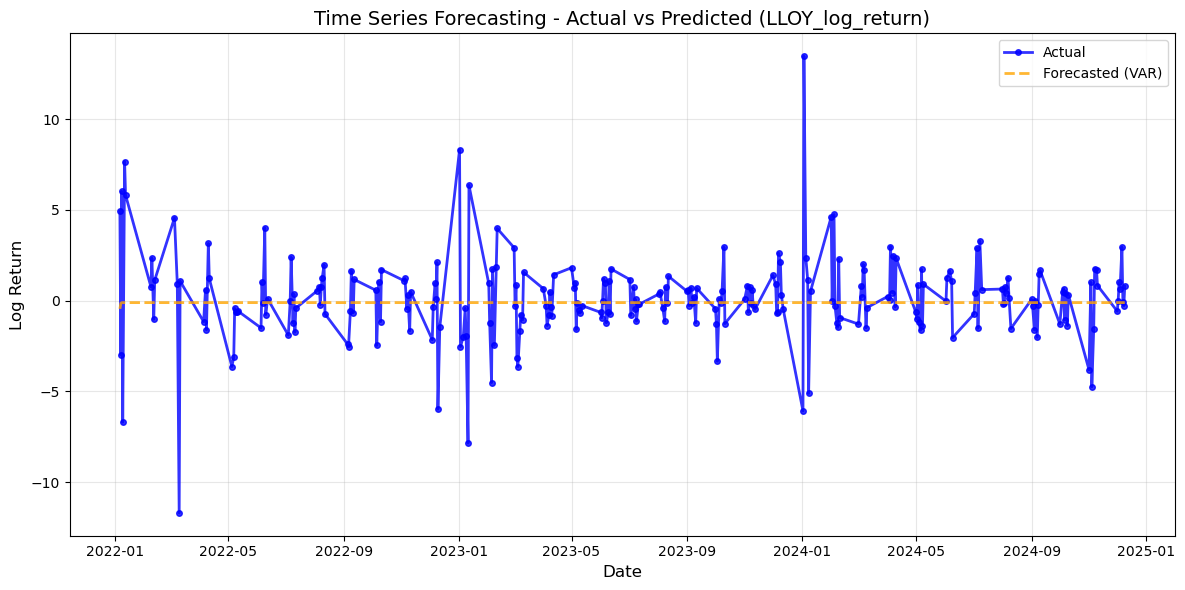

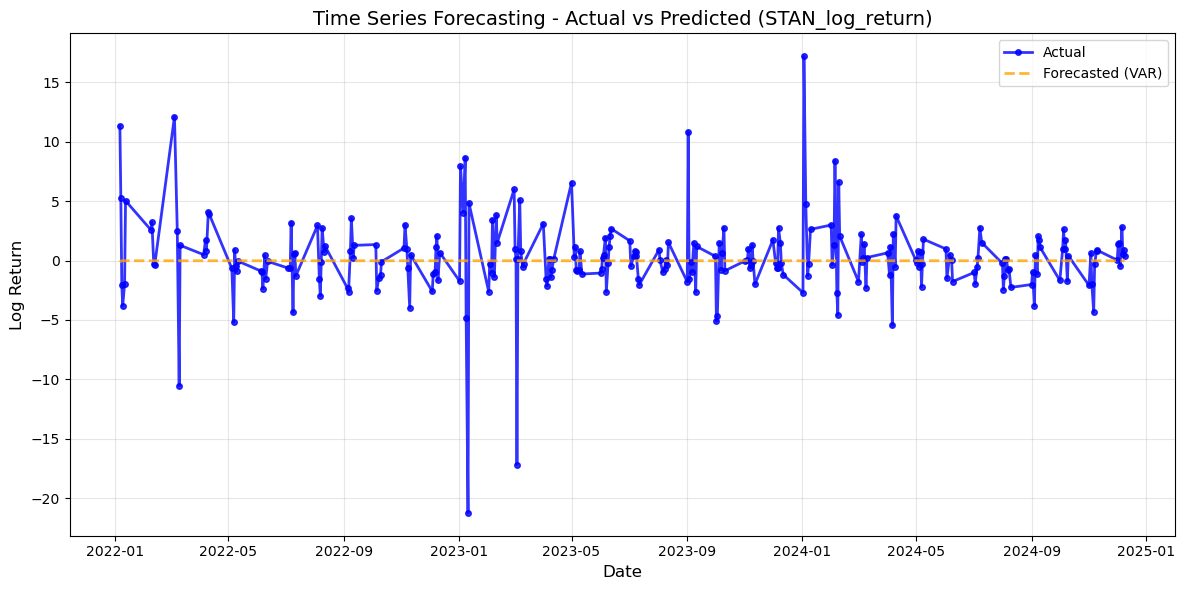

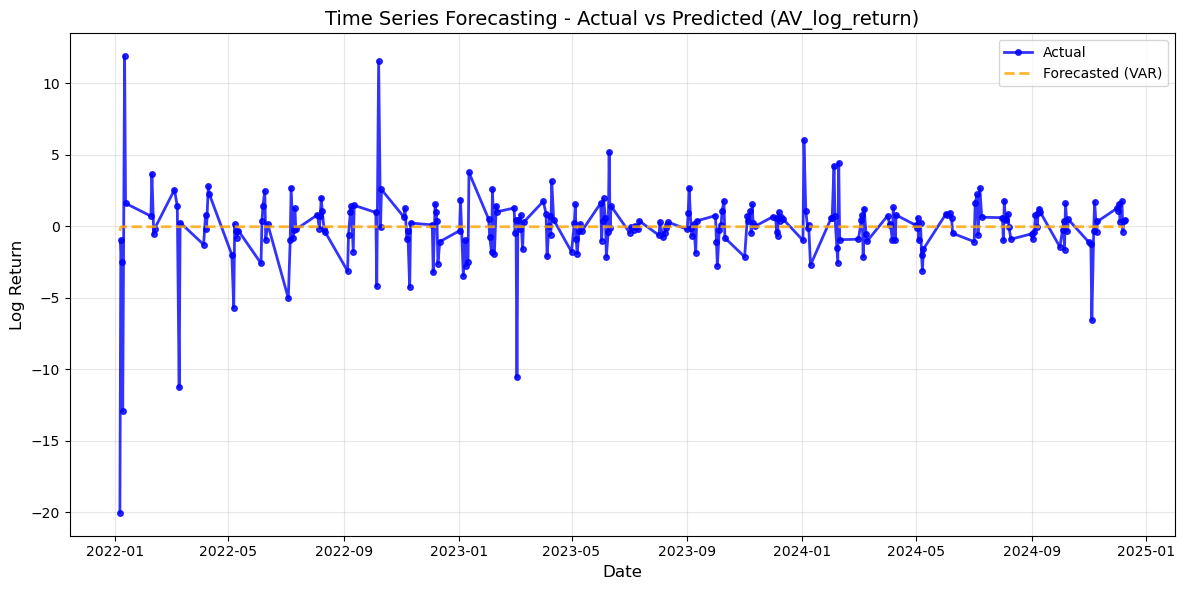

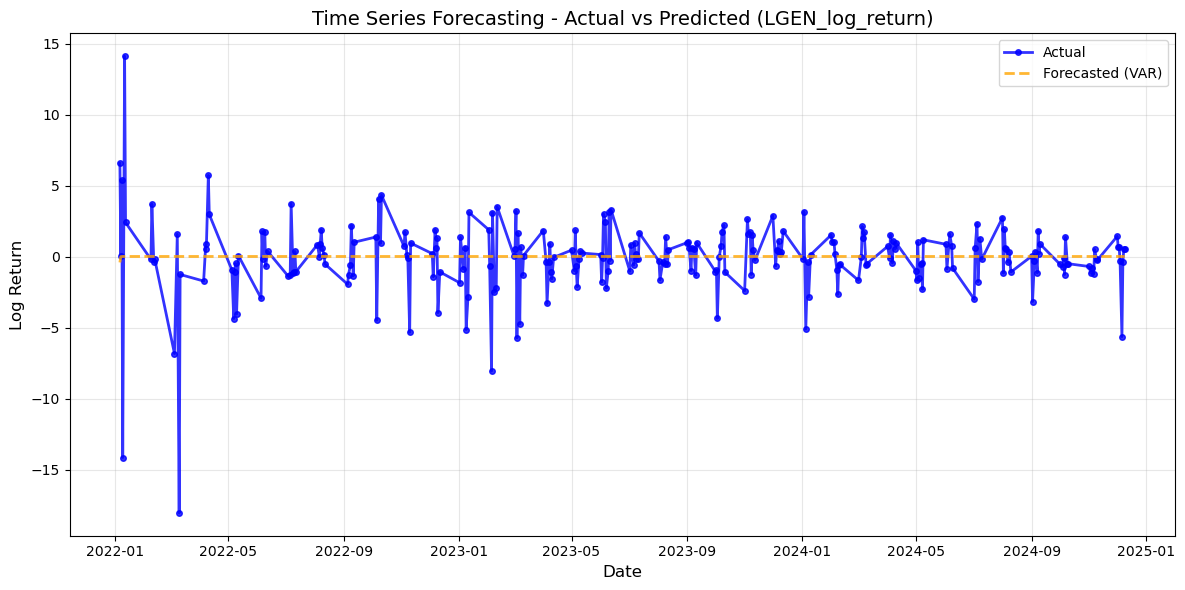

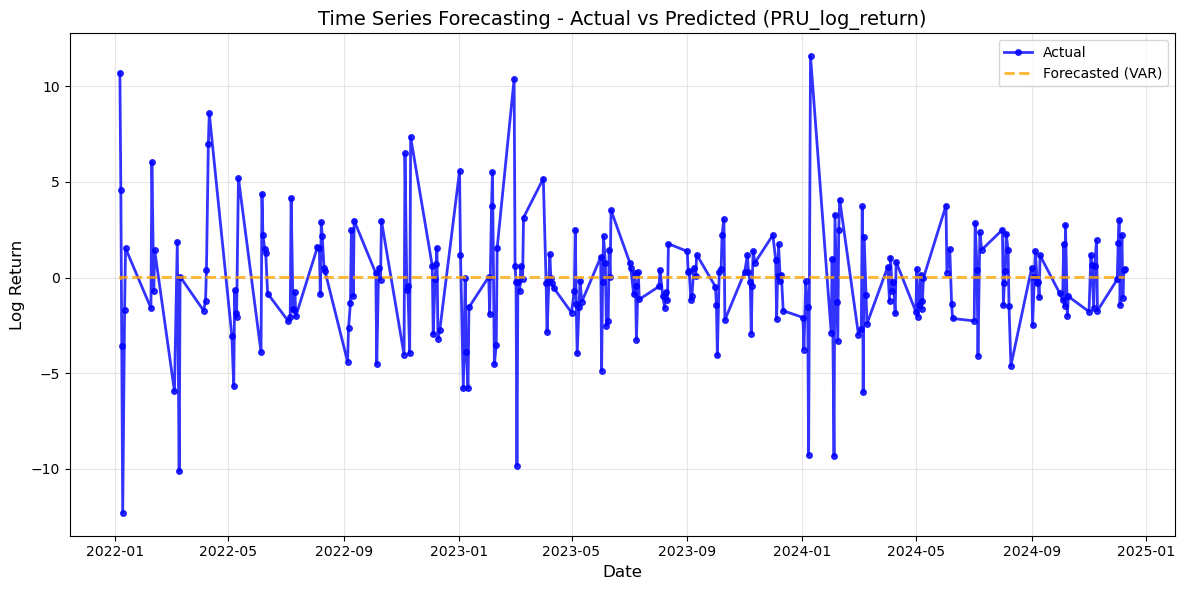

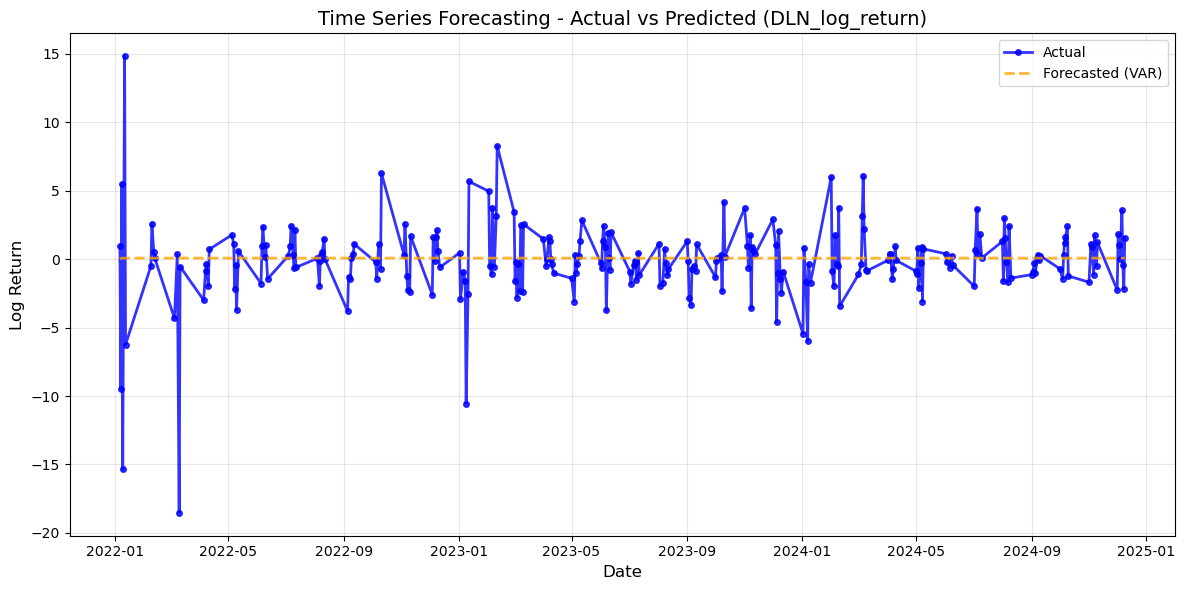

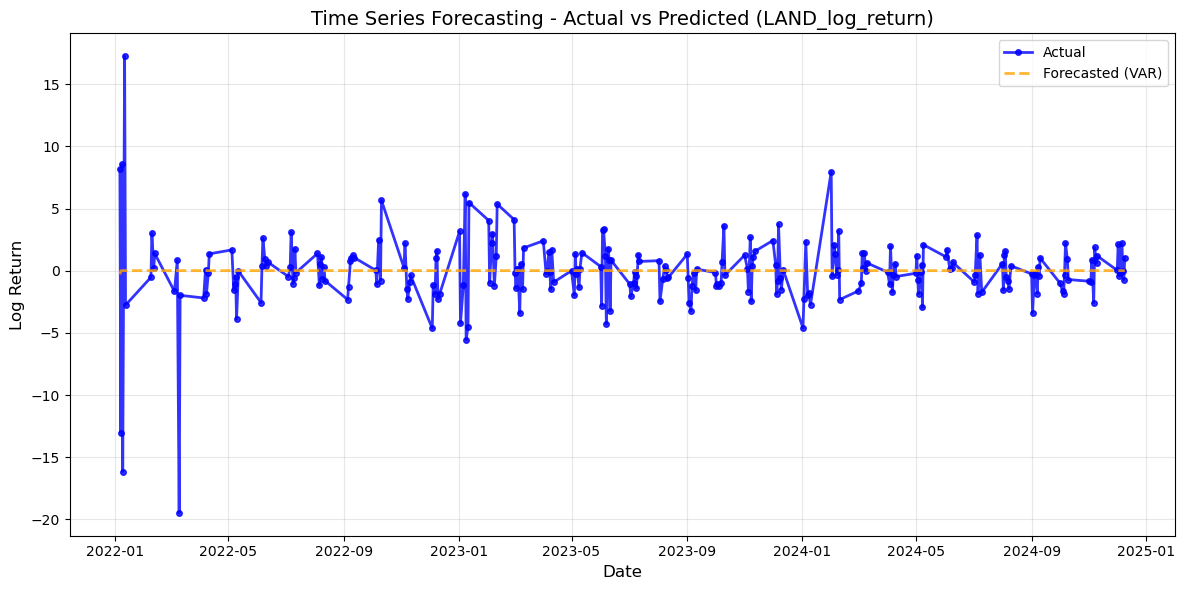


Performing Residual Diagnostics...

Ljung-Box Test for Residuals of BARC_log_return:
    lb_stat  lb_pvalue
5  3.965175   0.554441

Ljung-Box Test for Residuals of LLOY_log_return:
    lb_stat  lb_pvalue
5  8.700067   0.121642

Ljung-Box Test for Residuals of NWG_log_return:
   lb_stat  lb_pvalue
5  8.45496    0.13288

Ljung-Box Test for Residuals of STAN_log_return:
    lb_stat  lb_pvalue
5  0.859148   0.973108

Ljung-Box Test for Residuals of AV_log_return:
    lb_stat  lb_pvalue
5  8.144454   0.148452

Ljung-Box Test for Residuals of LGEN_log_return:
     lb_stat  lb_pvalue
5  34.466015   0.000002

Ljung-Box Test for Residuals of PRU_log_return:
   lb_stat  lb_pvalue
5  7.08388   0.214476

Ljung-Box Test for Residuals of DLN_log_return:
    lb_stat     lb_pvalue
5  36.08618  9.128452e-07

Ljung-Box Test for Residuals of LAND_log_return:
     lb_stat  lb_pvalue
5  19.397406   0.001621

MSE and RMSE Summary Table for VAR Model:
                       MSE      RMSE
BARC_log_return   9

In [27]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import pandas as pd

# Apply the VAR model to log return columns
print("Applying VAR Model...")

# Fit the VAR model on the training set
model_var = VAR(train[log_return_columns])  # Include all log return columns
var_results = model_var.fit(maxlags=1)  # Fit the model with up to 1 lags
print(log_return_columns)
# Forecast the log returns for the test set
forecast_steps = len(test)# Number of steps to forecast (equal to test set length)
var_forecast = var_results.forecast(train[log_return_columns].values[-5:], steps=forecast_steps)
print(var_forecast)
# Convert the forecasted results into a DataFrame
var_forecast_df = pd.DataFrame(var_forecast, columns=log_return_columns, index=test.index)
print(var_forecast_df)
# Initialize a dictionary to store MSE and RMSE values
mse_rmse_results = {}

# Calculate MSE and RMSE for each column
print("\nMSE and RMSE for VAR Model:")
for col in log_return_columns:
    # Calculate (MSE)and (RMSE)
    mse = mean_squared_error(test[col], var_forecast_df[col])
    rmse = sqrt(mse)
    mse_rmse_results[col] = {'MSE': mse, 'RMSE': rmse}
    
    # Print the MSE and RMSE
    print(f"{col} - MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
# Ensure temporal order is correct for time series
test = test.sort_values(by='date').reset_index(drop=True)
var_forecast_df = var_forecast_df.sort_index()  # Align forecast with test data

    
    # Create time-series style plots for VAR predictions
for col in log_return_columns:
    plt.figure(figsize=(12, 6))
    
    # Plot Actual Values
    plt.plot(
        test['date'], test[col], 
        label='Actual', color='blue', linewidth=2, marker='o', markersize=4, alpha=0.8
    )
    
    # Plot Predicted Values
    plt.plot(
        test['date'], var_forecast_df[col], 
        label='Forecasted (VAR)', color='orange', linestyle='--', linewidth=2, alpha=0.8
    )
    
    # Graph Styling
    plt.title(f"Time Series Forecasting - Actual vs Predicted ({col})", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Log Return", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Step 5: Residual Diagnostics
print("\nPerforming Residual Diagnostics...")
residuals = var_results.resid
for col in residuals.columns:
    print(f"\nLjung-Box Test for Residuals of {col}:")
    ljung_box_result = acorr_ljungbox(residuals[col], lags=[5], return_df=True)
    print(ljung_box_result)

    
    
# Display the RMSE results in a DataFrame
import pandas as pd
mse_rmse_df = pd.DataFrame(mse_rmse_results).T
print("\nMSE and RMSE Summary Table for VAR Model:")
print(mse_rmse_df)


#  8. Apply the Long Short-Term Memory (LSTM) Model
Each column's log returns are anticipated independently using the LSTM model.
Time series forecasting is a common use of LSTM. It is an RNN type that tracks temporal dependencies in data by employing memory cells and gates.

The steps in the workflow are:

1. Rearranging the data to fit the LSTM format. 
2. The log return is supplied into the model at a predetermined time (Input (X_train)).The model attempts to forecast the equivalent log return as the output (y_train).
3. constructing an LSTM model and training it for every log return column.
4. prediction of the test set's log returns.
5. Calculating each column's (MSE) and (RMSE) in order to assess performance.
6. Displaying each column's actual and expected values visually.


Applying LSTM Model with Overfitting Prevention...

Processing column: BARC_log_return


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 15.1233 - val_loss: 17.1740
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.6635 - val_loss: 12.2496
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7291 - val_loss: 6.5558
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3006 - val_loss: 3.1484
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9093 - val_loss: 1.4655
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0134 - val_loss: 0.9104
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6783 - val_loss: 0.4634
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7338 - val_loss: 0.1842
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4139 - val_loss: 0.0949
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5001 - val_loss: 0.1336
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3864 - val_loss: 0.0683
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0125 - v

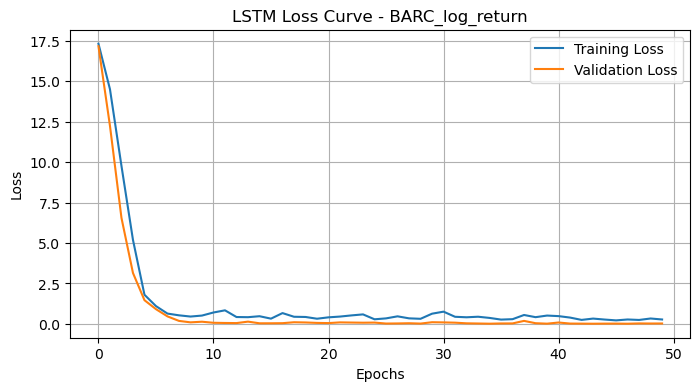

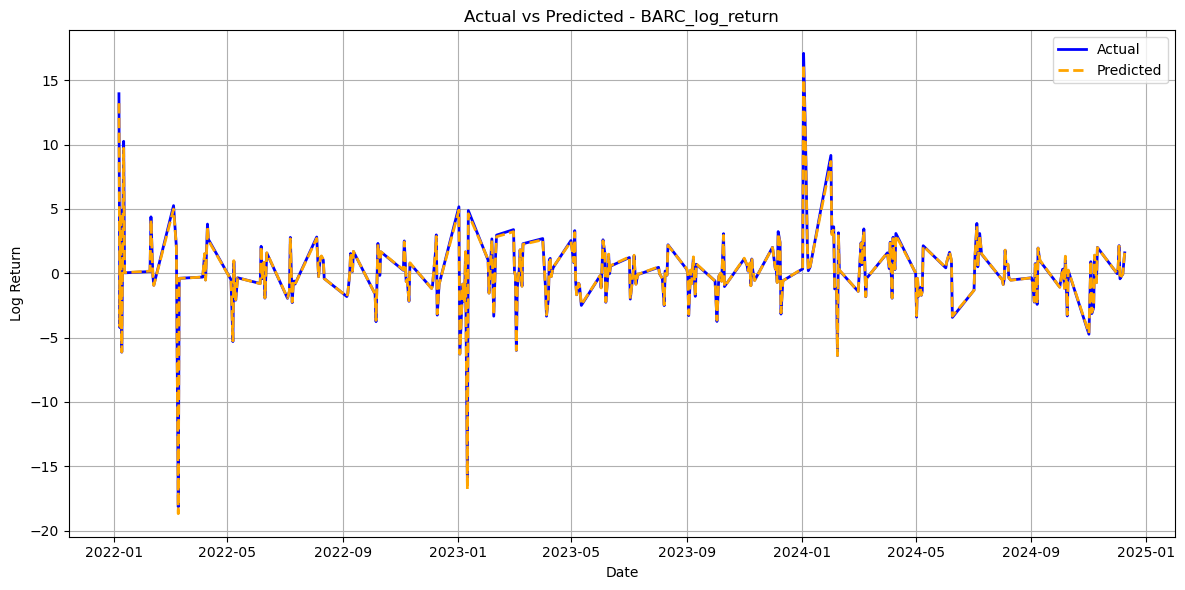


Processing column: LLOY_log_return
Epoch 1/50


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 14.1328 - val_loss: 11.7107
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4287 - val_loss: 6.8634
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9629 - val_loss: 2.4878
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5911 - val_loss: 0.4277
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4664 - val_loss: 0.1618
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3654 - val_loss: 0.1158
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4000 - val_loss: 0.1016
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2829 - val_loss: 0.0925
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2739 - val_loss: 0.0793
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3930 - val_loss: 0.0422
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3207 - val_loss: 0.1532
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4317 - val_loss: 0.06

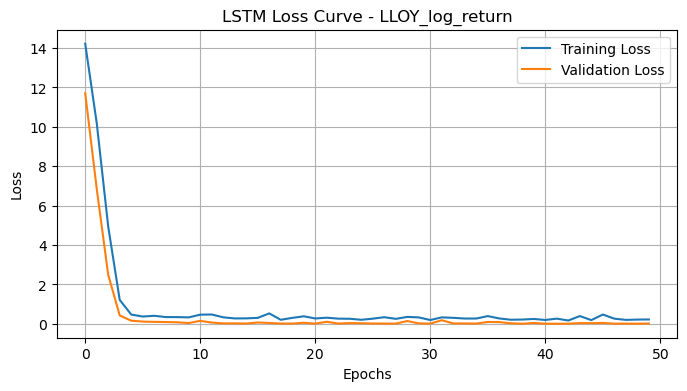

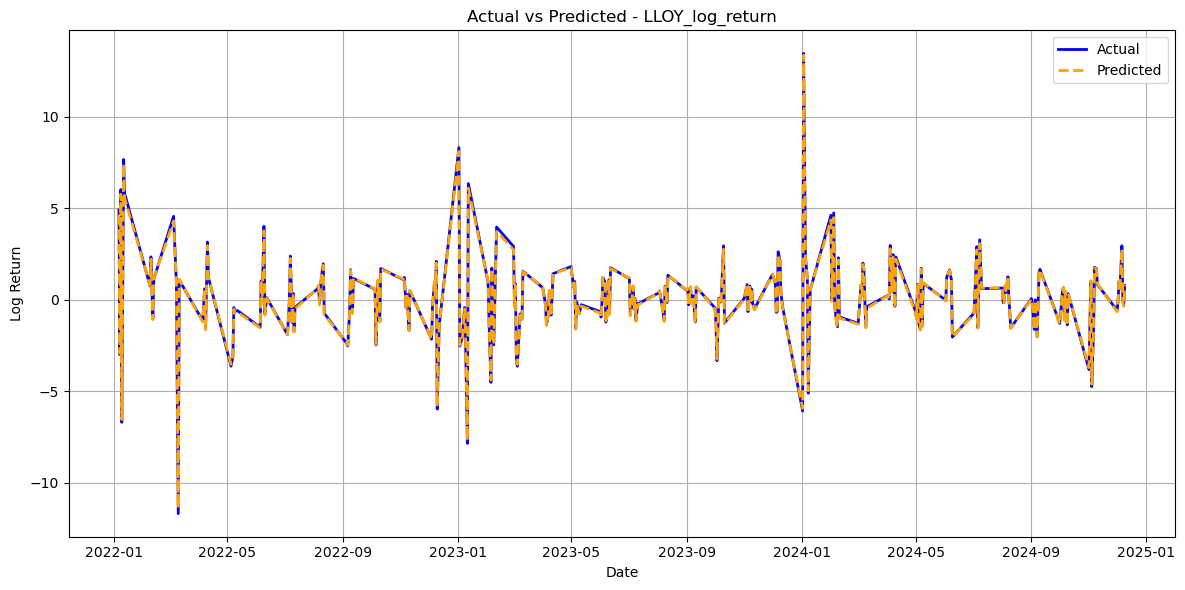


Processing column: NWG_log_return
Epoch 1/50


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 16.1403 - val_loss: 13.8461
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4476 - val_loss: 9.0302
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1134 - val_loss: 4.3393
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1452 - val_loss: 1.9564
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8199 - val_loss: 0.9725
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8138 - val_loss: 0.6605
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5713 - val_loss: 0.3992
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4982 - val_loss: 0.1507
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3499 - val_loss: 0.1208
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4212 - val_loss: 0.0409
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4958 - val_loss: 0.1158
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5514 - val_loss: 0.0

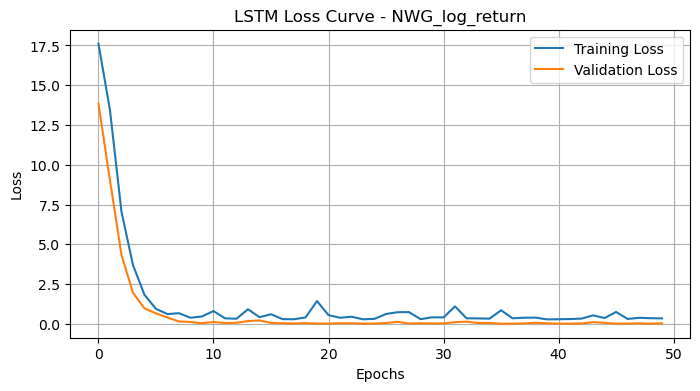

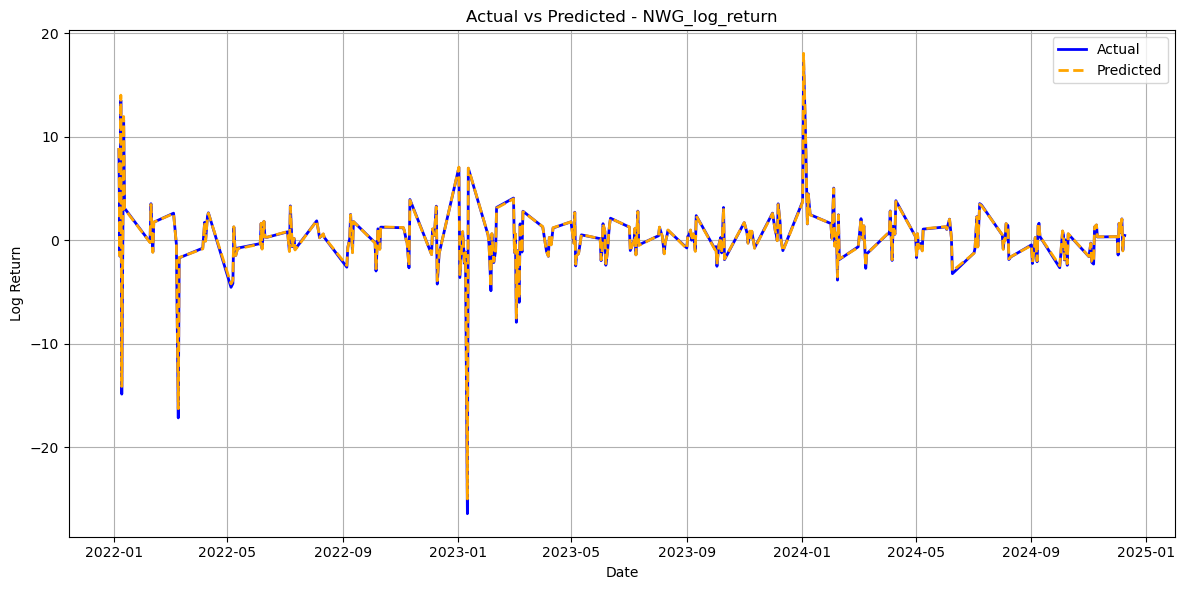


Processing column: STAN_log_return


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8.0708 - val_loss: 11.8350
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2338 - val_loss: 8.0298
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8638 - val_loss: 3.3363
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6150 - val_loss: 0.7410
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5148 - val_loss: 0.1213
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2444 - val_loss: 0.0818
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2451 - val_loss: 0.0859
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2175 - val_loss: 0.0597
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2354 - val_loss: 0.0514
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2099 - val_loss: 0.0397
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2491 - val_loss: 0.0663
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2086 - val

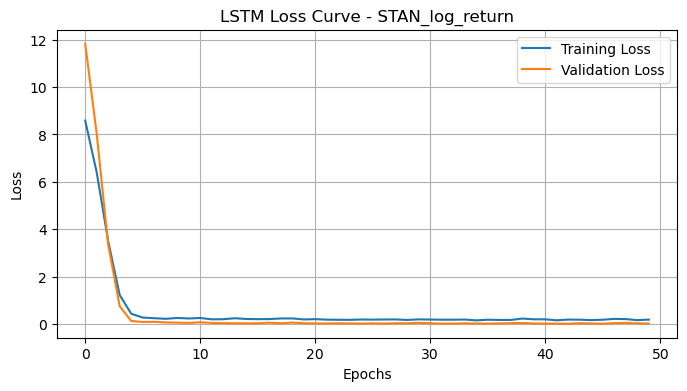


Processing column: AV_log_return


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 10.6400 - val_loss: 8.4087
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7953 - val_loss: 4.5335
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3031 - val_loss: 1.3438
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0433 - val_loss: 0.2570
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3504 - val_loss: 0.1584
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2664 - val_loss: 0.0693
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1922 - val_loss: 0.0259
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2148 - val_loss: 0.0291
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2210 - val_loss: 0.0524
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1883 - val_loss: 0.0216
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2093 - val_loss: 0.0181
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2138 - val_


Processing column: LGEN_log_return
Epoch 1/50


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 12.1114 - val_loss: 11.2202
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8099 - val_loss: 6.8611
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9845 - val_loss: 2.6315
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5574 - val_loss: 0.5416
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4052 - val_loss: 0.1229
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2837 - val_loss: 0.1265
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3244 - val_loss: 0.1162
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3180 - val_loss: 0.0282
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1964 - val_loss: 0.0334
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2178 - val_loss: 0.0239
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2051 - val_loss: 0.0414
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2872 - val_loss: 

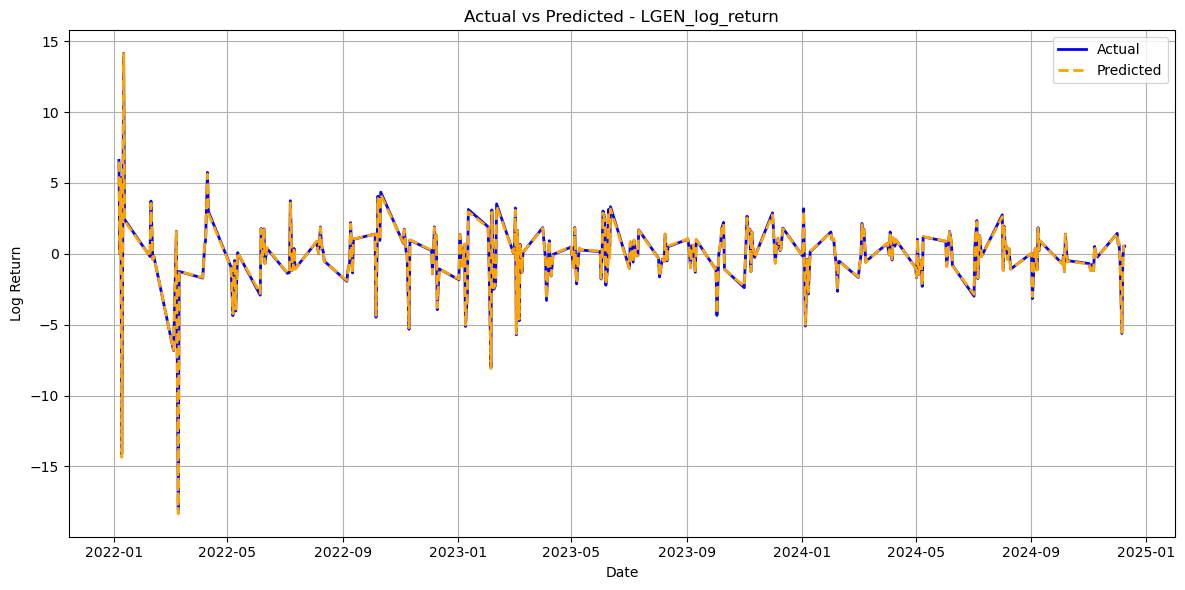


Processing column: PRU_log_return
Epoch 1/50


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 10.5506 - val_loss: 14.1451
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6617 - val_loss: 8.8394
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7509 - val_loss: 2.2945
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3261 - val_loss: 0.2763
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3537 - val_loss: 0.3160
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4685 - val_loss: 0.2221
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3066 - val_loss: 0.1343
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2504 - val_loss: 0.1128
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2329 - val_loss: 0.0851
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2104 - val_loss: 0.0635
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1964 - val_loss: 0.0650
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2269 - val_loss: 0.04

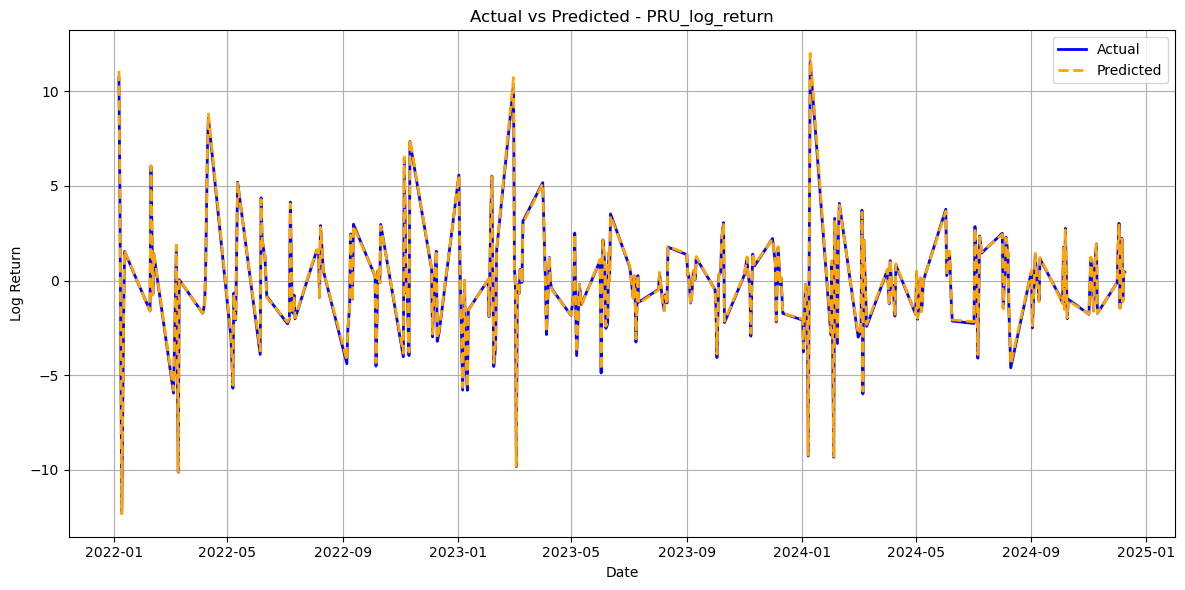


Processing column: DLN_log_return
Epoch 1/50


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.1186 - val_loss: 5.9236
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4056 - val_loss: 3.7383
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2325 - val_loss: 1.6273
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2819 - val_loss: 0.6074
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4396 - val_loss: 0.2127
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2185 - val_loss: 0.1134
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1659 - val_loss: 0.0825
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1731 - val_loss: 0.1033
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1133 - val_loss: 0.0584
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1746 - val_loss: 0.1135
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1630 - val_loss: 0.0515
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1605 - val_loss: 0.0650

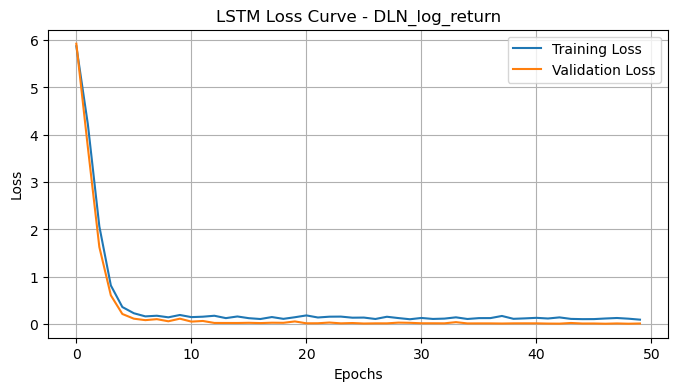

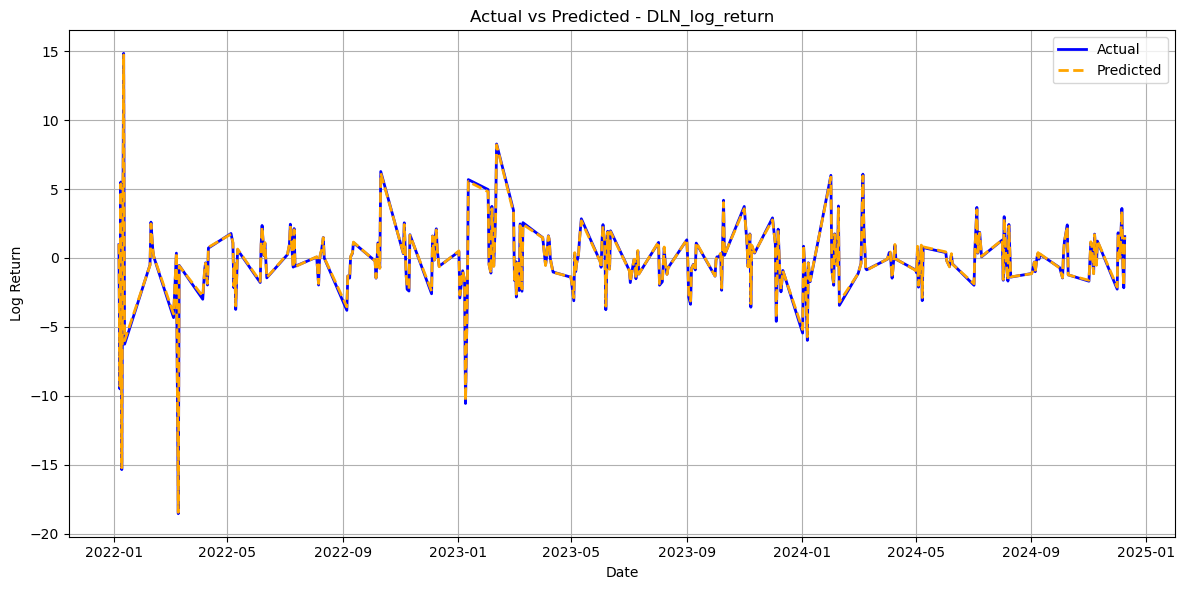


Processing column: LAND_log_return


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 6.1148 - val_loss: 12.7983
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7613 - val_loss: 9.0516
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7945 - val_loss: 4.6883
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4007 - val_loss: 2.0789
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6766 - val_loss: 0.6038
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2567 - val_loss: 0.1986
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1812 - val_loss: 0.0799
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1396 - val_loss: 0.0704
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1482 - val_loss: 0.0856
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1174 - val_loss: 0.0542
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1985 - val_loss: 0.0994
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1438 - val_


LSTM RMSE Results:
                      MSE      RMSE
BARC_log_return  0.014872  0.121949
LLOY_log_return  0.007316  0.085532
NWG_log_return   0.024680  0.157099
STAN_log_return  0.011324  0.106416
AV_log_return    0.007243  0.085107
LGEN_log_return  0.004363  0.066053
PRU_log_return   0.008145  0.090247
DLN_log_return   0.009394  0.096922
LAND_log_return  0.008899  0.094333


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

# Apply LSTM Model to Each Log Return Column
print("Applying LSTM Model with Overfitting Prevention...")

# Initialize a dictionary to store RMSE results
lstm_mse_rmse_results = {}

for col in log_return_columns:
    print(f"\nProcessing column: {col}")
    
    # Prepare the data
    X_train = train[col].values.reshape(-1, 1, 1)  # Reshape for LSTM input [samples, timesteps, features]
    y_train = train[col].values
    X_test = test[col].values.reshape(-1, 1, 1)

    # Build the LSTM model
    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(1, 1)),  # LSTM layer with 50 neurons
        Dropout(0.2),  # Dropout to prevent overfitting
        Dense(1)  # Output layer
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    # Train the model with validation split
    history = lstm_model.fit(X_train, y_train, epochs=50, validation_split=0.1, verbose=1)
    
    # to Make predictions
    lstm_preds = lstm_model.predict(X_test).flatten()
    
    # Calculate RMSE
    mse = mean_squared_error(test[col], lstm_preds)
    rmse = sqrt(mse)
    lstm_mse_rmse_results[col] = {'MSE': mse, 'RMSE': rmse}
    print(f"{col} - RMSE: {rmse:.4f}")
    
    # Plot Training vs Validation Loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"LSTM Loss Curve - {col}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Actual vs Predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test['date'], test[col], label='Actual', color='blue', linewidth=2)
    plt.plot(test['date'], lstm_preds, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"Actual vs Predicted - {col}")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Display RMSE Results
lstm_rmse_df = pd.DataFrame(lstm_mse_rmse_results).T
print("\nLSTM RMSE Results:")
print(lstm_rmse_df)


# 9. Implementing the AutoRegressive Integrated Moving Average Model  
In this phase, we utilize the ARIMA model for each column independently to predict the log returns.  
The three elements of the widely recognized time series model ARIMA are described below:  

Auto regression, or AR, pertains to the connection between a time series and its past values.

**I (Integration)**: Differencing the data to achieve stationarity.
**MA (Moving Average)**: The relationship between a time series and the lagged forecast errors.
The workflow includes:

1. Fitting an ARIMA model to each log return column.
2. Forecasting the log returns for the test set.
3. Calculating the MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) for each column.
4. Visualizing the actual vs predicted values for each column.


In [29]:
pip install pmdarima


Applying ARIMA Model with Fixed Parameters...

Processing column: BARC_log_return
BARC_log_return - RMSE: 3.0857

Processing column: LLOY_log_return
LLOY_log_return - RMSE: 2.3439

Processing column: NWG_log_return
NWG_log_return - RMSE: 3.4246

Processing column: STAN_log_return
STAN_log_return - RMSE: 3.3385

Processing column: AV_log_return
AV_log_return - RMSE: 2.6156

Processing column: LGEN_log_return


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LGEN_log_return - RMSE: 2.6054

Processing column: PRU_log_return
PRU_log_return - RMSE: 3.0396

Processing column: DLN_log_return
DLN_log_return - RMSE: 2.8494

Processing column: LAND_log_return
LAND_log_return - RMSE: 2.9310

ARIMA RMSE Results:
                       MSE      RMSE
BARC_log_return   9.521403  3.085677
LLOY_log_return   5.493994  2.343927
NWG_log_return   11.727770  3.424583
STAN_log_return  11.145395  3.338472
AV_log_return     6.841534  2.615633
LGEN_log_return   6.788039  2.605387
PRU_log_return    9.239405  3.039639
DLN_log_return    8.119130  2.849409
LAND_log_return   8.590522  2.930959

Visualizing ARIMA Results for Column: BARC_log_return


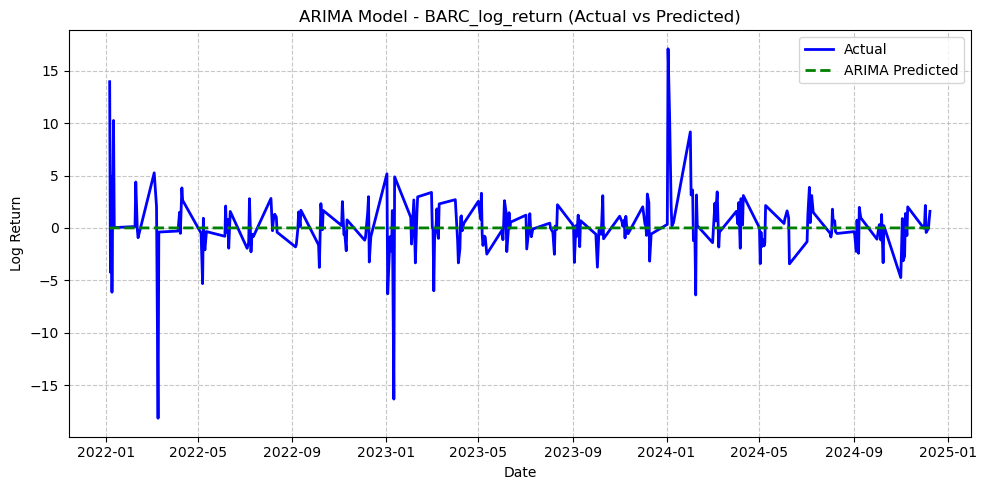


Visualizing ARIMA Results for Column: LLOY_log_return


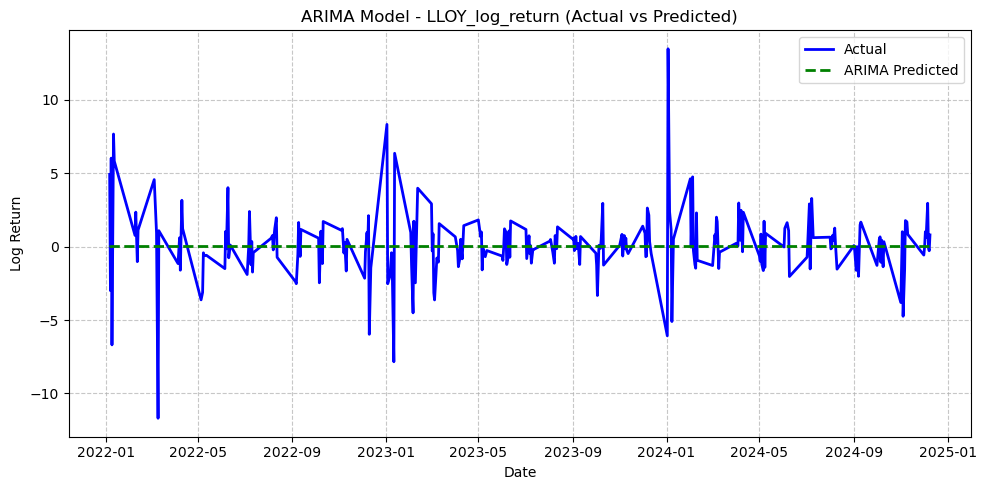


Visualizing ARIMA Results for Column: NWG_log_return


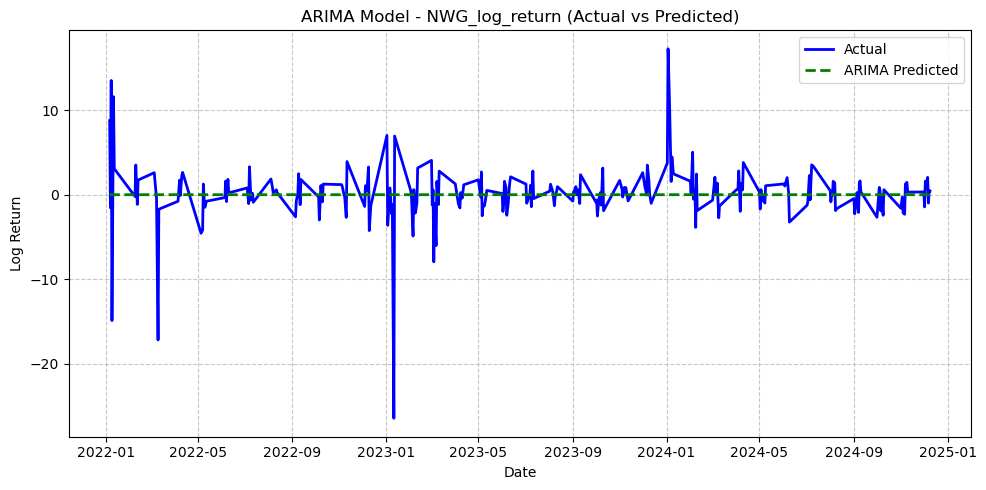


Visualizing ARIMA Results for Column: STAN_log_return


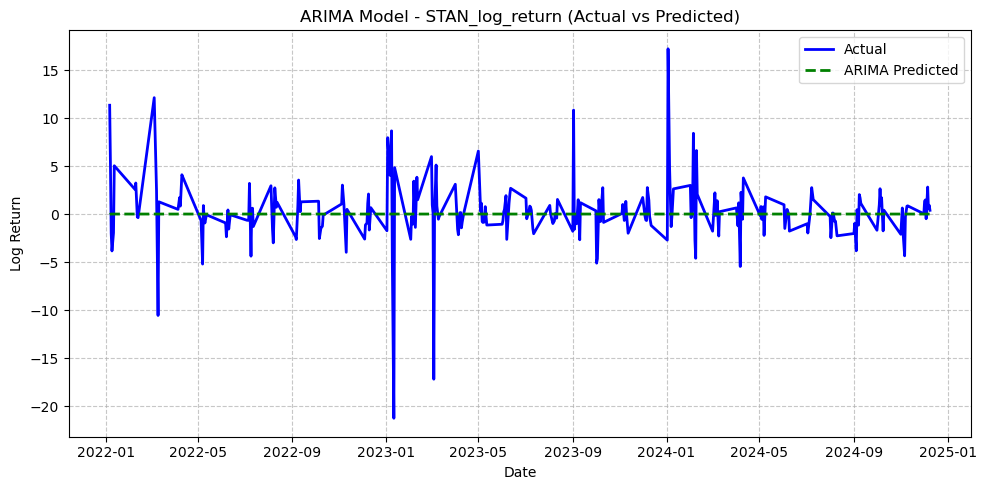


Visualizing ARIMA Results for Column: AV_log_return


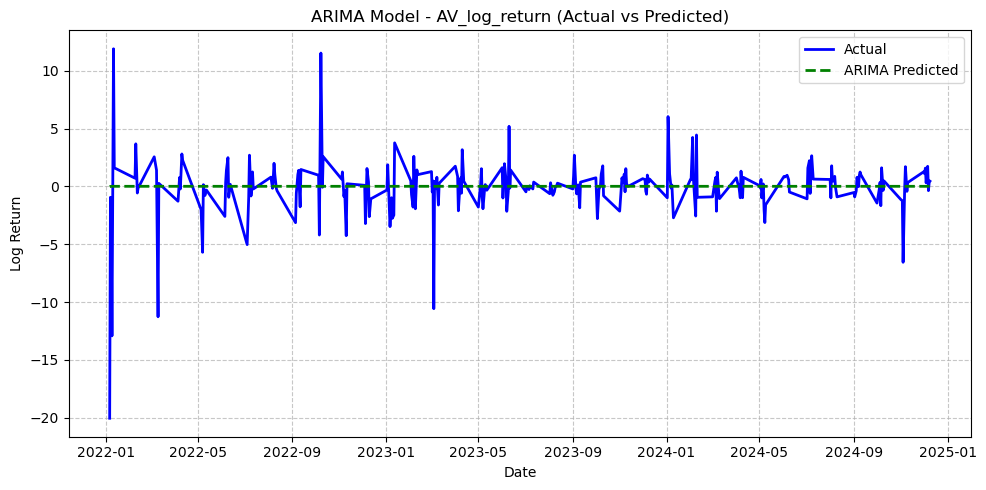


Visualizing ARIMA Results for Column: LGEN_log_return



Visualizing ARIMA Results for Column: PRU_log_return



Visualizing ARIMA Results for Column: DLN_log_return


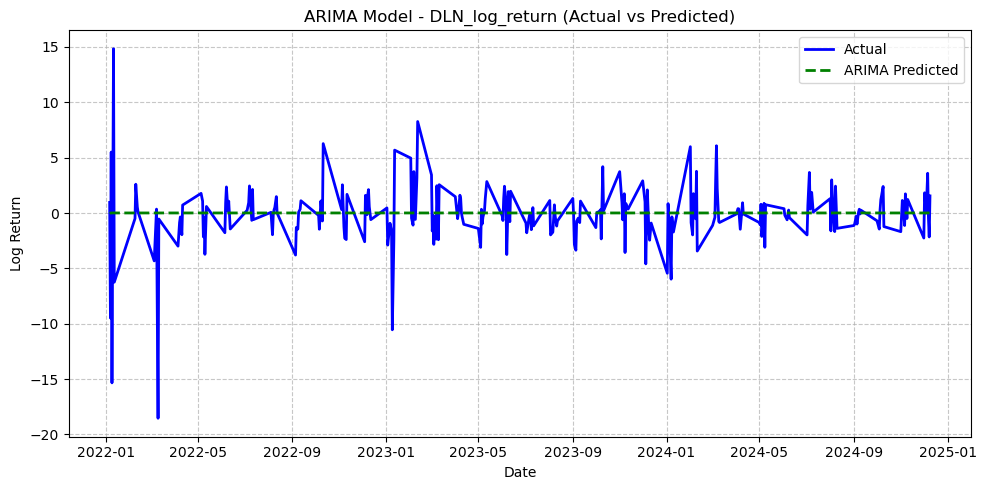


Visualizing ARIMA Results for Column: LAND_log_return


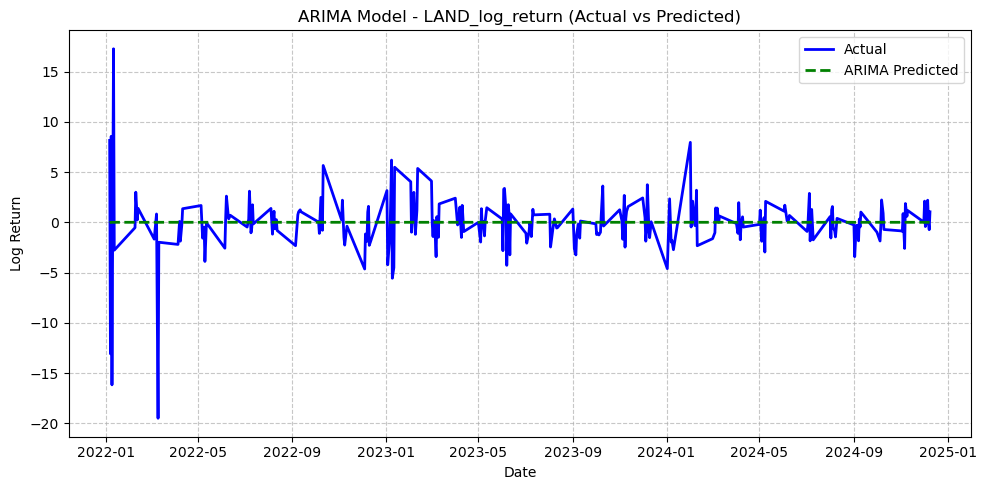

In [30]:
# Manual ARIMA implementation with fixed parameters
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# ARIMA Model for Each Log Return Column
print("Applying ARIMA Model with Fixed Parameters...")

# Initialize a dictionary to store RMSE results
arima_mse_rmse_results = {}

for col in log_return_columns:
    print(f"\nProcessing column: {col}")
    try:
        # Fit ARIMA model (replace with manually tested (p,d,q) values)
        arima_model = ARIMA(train[col], order=(1, 0, 1))  # Example parameters
        arima_results = arima_model.fit()

        # Forecast on test set
        arima_preds = arima_results.forecast(steps=len(test))
        
        # Calculate RMSE
        mse = mean_squared_error(test[col], arima_preds)
        rmse = sqrt(mse)
        arima_mse_rmse_results[col] = {'MSE': mse, 'RMSE': rmse}
        print(f"{col} - RMSE: {rmse:.4f}")

    except Exception as e:
        print(f"ARIMA failed for {col} due to: {e}")
        arima_mse_rmse_results[col] = {'MSE': None, 'RMSE': None}

# Display ARIMA results
arima_rmse_df = pd.DataFrame(arima_mse_rmse_results).T
print("\nARIMA RMSE Results:")
print(arima_rmse_df)


import matplotlib.pyplot as plt
import seaborn as sns

# ARIMA Visualization for Each Log Return Column
for col in log_return_columns:
    if arima_mse_rmse_results[col]['MSE'] is not None:
        print(f"\nVisualizing ARIMA Results for Column: {col}")

        # Actual vs Predicted Plot
        plt.figure(figsize=(10, 5))
        plt.plot(test['date'], test[col], label='Actual', color='blue', linewidth=2)
        plt.plot(test['date'], arima_preds, label='ARIMA Predicted', color='green', linestyle='--', linewidth=2)
        plt.title(f"ARIMA Model - {col} (Actual vs Predicted)")
        plt.xlabel("Date")
        plt.ylabel("Log Return")
        plt.legend()
        plt.grid(linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()








# 10: Combined Actual vs Predicted Graphs for Each Column

In this step, we generate **combined graphs** for each log return column.  
These graphs display the actual log return values and the predicted values from the three models (**VAR**, **LSTM**, and **ARIMA**).  
This visualization helps us compare the performance of the models visually.

The graph includes:
1. **Actual Values** (Black line)  
2. **VAR Predicted Values** (Red dashed line)  
3. **LSTM Predicted Values** (Green dashed line)  
4. **ARIMA Predicted Values** (Orange dashed line)


Generating Enhanced Combined Graphs for Each Column...
Processing column: BARC_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


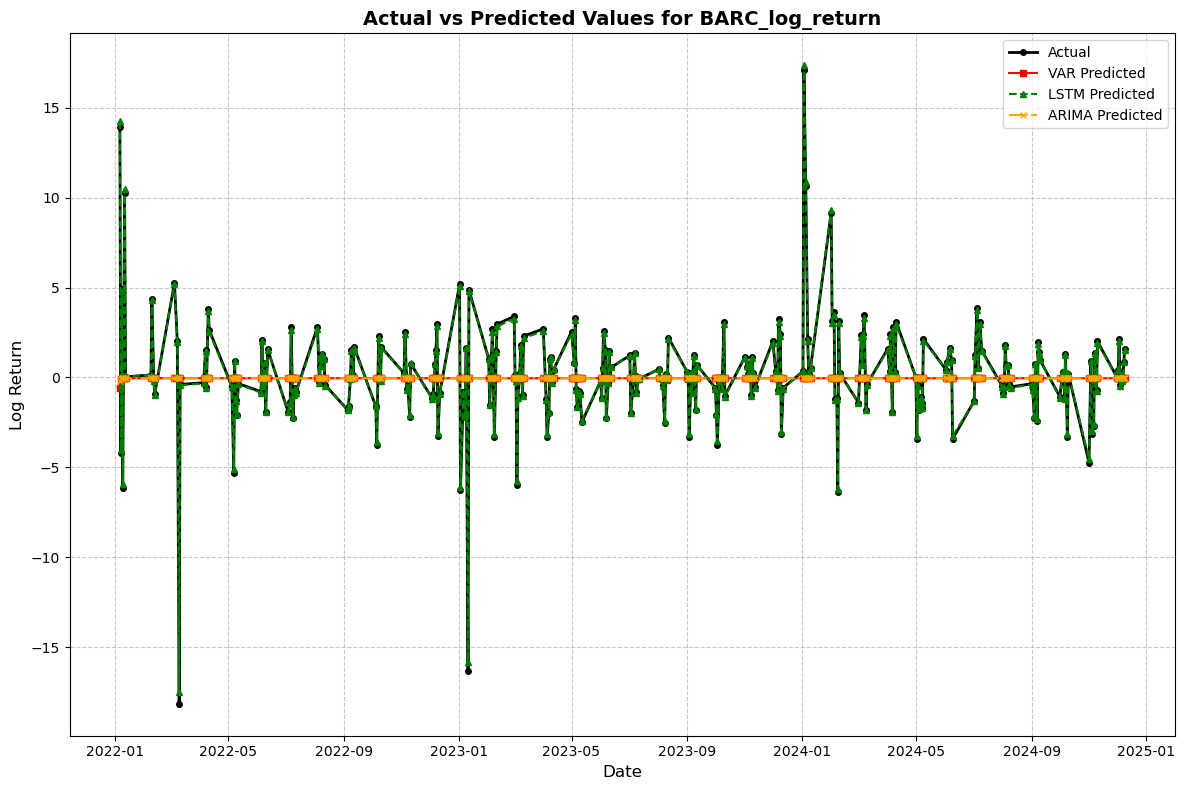

Processing column: LLOY_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Processing column: NWG_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


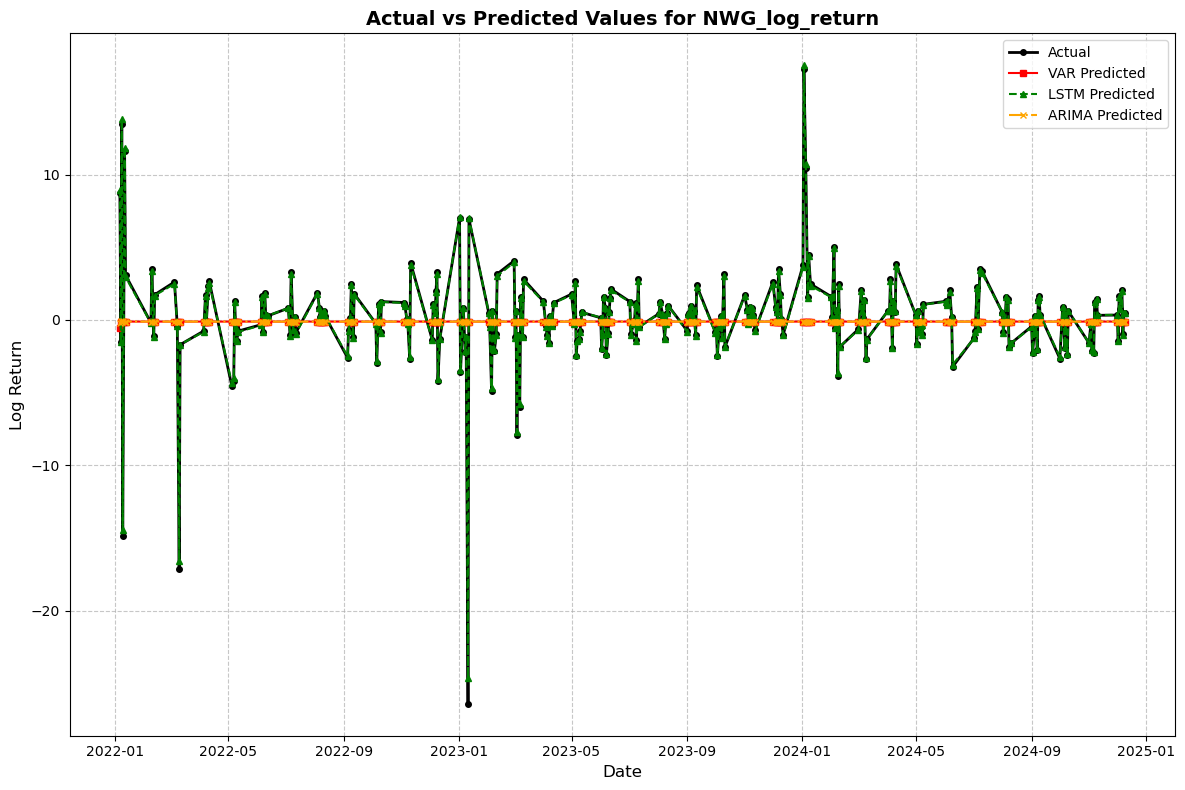

Processing column: STAN_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


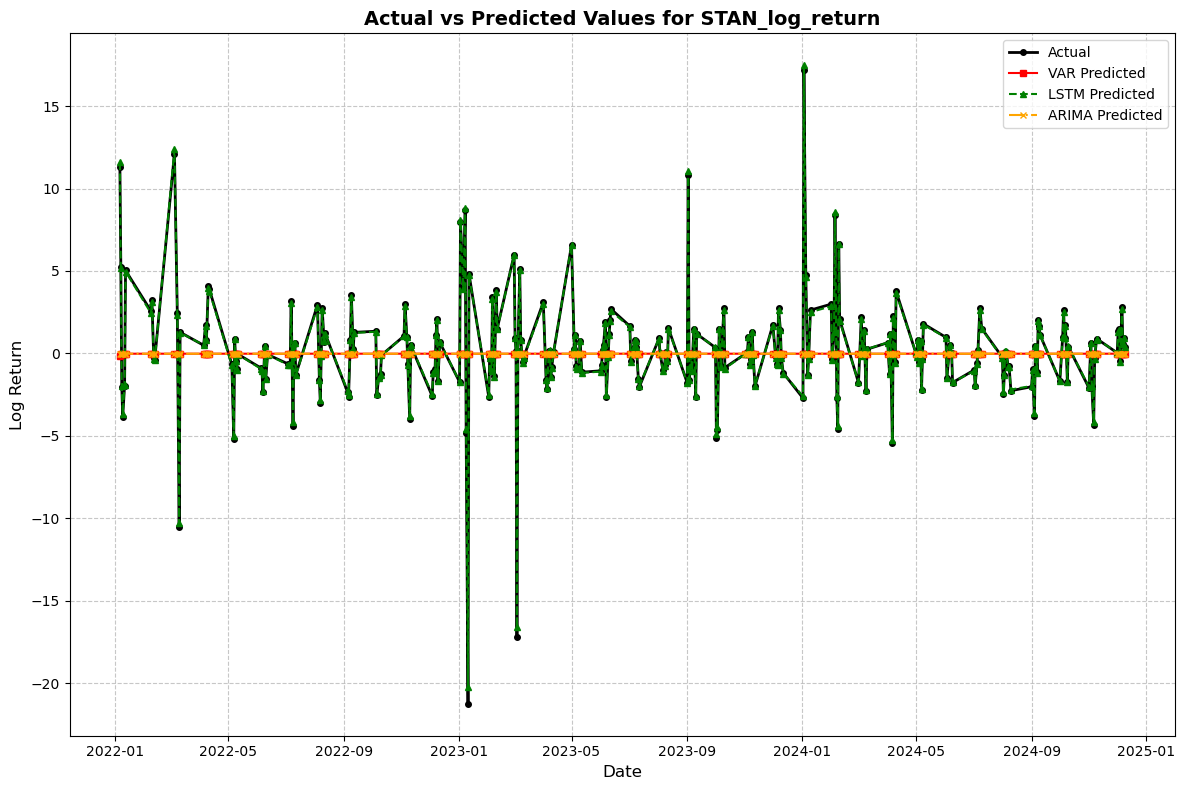

Processing column: AV_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


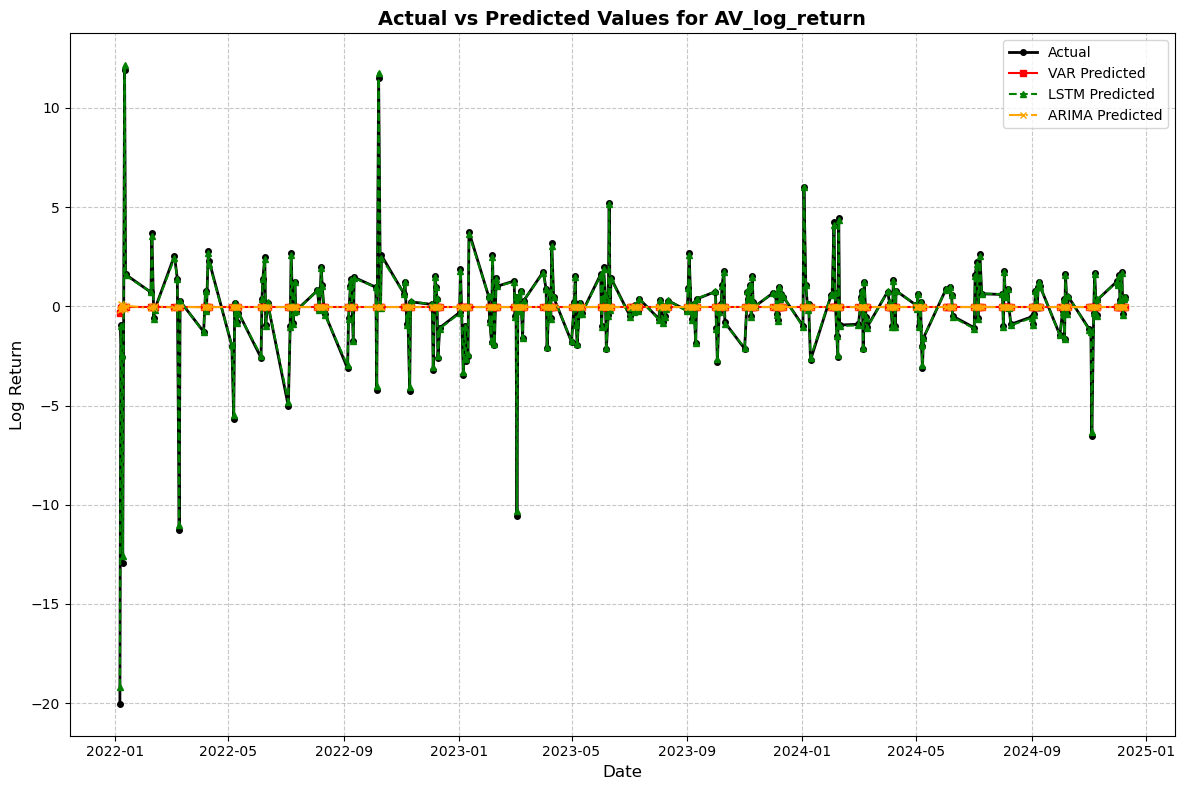

Processing column: LGEN_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing column: PRU_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Processing column: DLN_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


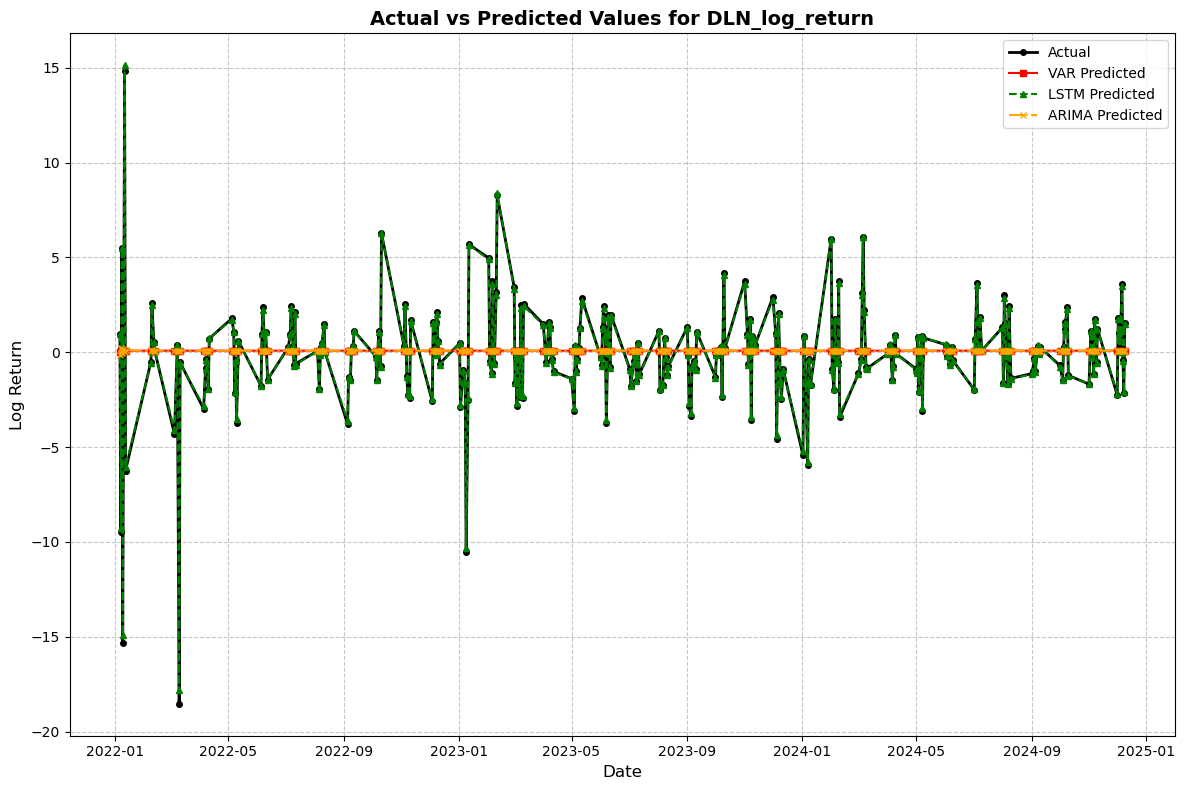

Processing column: LAND_log_return
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


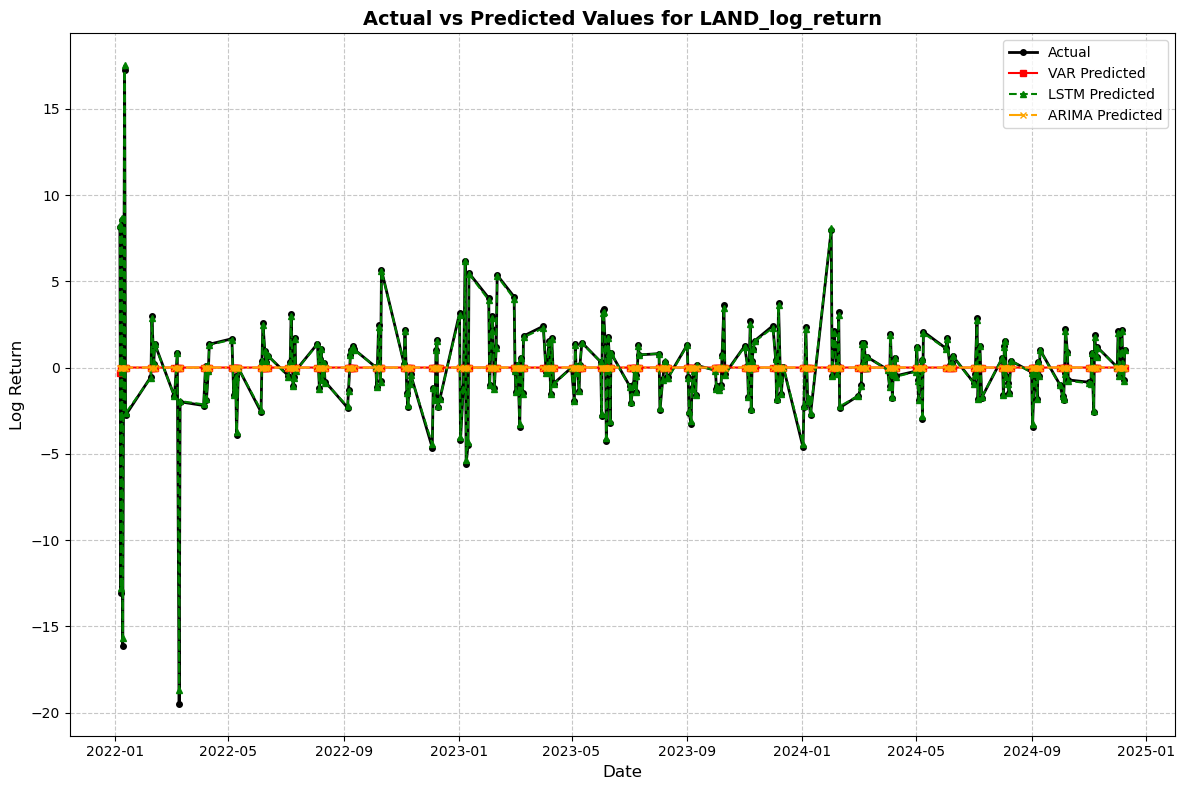

In [31]:
print("Generating Enhanced Combined Graphs for Each Column...")

for col in log_return_columns:
    print(f"Processing column: {col}")
    
    # Extract VAR predictions
    var_preds = var_forecast_df[col]
    
    # Extract LSTM predictions
    X_test_lstm = test[col].values.reshape(-1, 1, 1)
    lstm_preds = lstm_model.predict(X_test_lstm).flatten()
    
    # Extract ARIMA predictions
    arima_model = ARIMA(train[col], order=(1, 0, 1))
    arima_results = arima_model.fit()
    arima_preds = arima_results.forecast(steps=len(test))
    
    # Plot the actual and predicted values
    plt.figure(figsize=(12, 8))
    
    # Plot actual values
    plt.plot(test['date'], test[col], label='Actual', color='black', linewidth=2, marker='o', markersize=4)
    
    # Plot VAR predictions
    plt.plot(test['date'], var_preds, label='VAR Predicted', color='red', linestyle='-', linewidth=1.5, marker='s', markersize=4)
    
    # Plot LSTM predictions
    plt.plot(test['date'], lstm_preds, label='LSTM Predicted', color='green', linestyle='--', linewidth=1.5, marker='^', markersize=4)
    
    # Plot ARIMA predictions
    plt.plot(test['date'], arima_preds, label='ARIMA Predicted', color='orange', linestyle='-.', linewidth=1.5, marker='x', markersize=4)
    
    # Add titles and labels
    plt.title(f'Actual vs Predicted Values for {col}', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Log Return', fontsize=12)
    
    # Customize legend
    plt.legend(fontsize=10, loc='best')
    
    # Add grid for better visualization
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Optimize layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()


#  11: Compare VAR, LSTM, and ARIMA Results

In this step, we consolidate the results of **VAR**, **LSTM**, and **ARIMA** models:
1. Combine the **RMSE** values from all three models into a single table.  
2. Calculate the **average RMSE** for each column across the three models.  
3. Identify which column has the best performance (lowest average RMSE).  
4. Visualize the average RMSE values using a bar chart for easy comparison.



Combined RMSE Table:
                 VAR_RMSE  LSTM_RMSE  ARIMA_RMSE
BARC_log_return  3.082023   0.121949    3.085677
LLOY_log_return  2.334694   0.085532    2.343927
NWG_log_return   3.423654   0.157099    3.424583
STAN_log_return  3.338469   0.106416    3.338472
AV_log_return    2.616114   0.085107    2.615633
LGEN_log_return  2.604680   0.066053    2.605387
PRU_log_return   3.041428   0.090247    3.039639
DLN_log_return   2.844030   0.096922    2.849409
LAND_log_return  2.930616   0.094333    2.930959

Data Types of RMSE Table:
VAR_RMSE      float64
LSTM_RMSE     float64
ARIMA_RMSE    float64
dtype: object


<Figure size 1200x800 with 0 Axes>

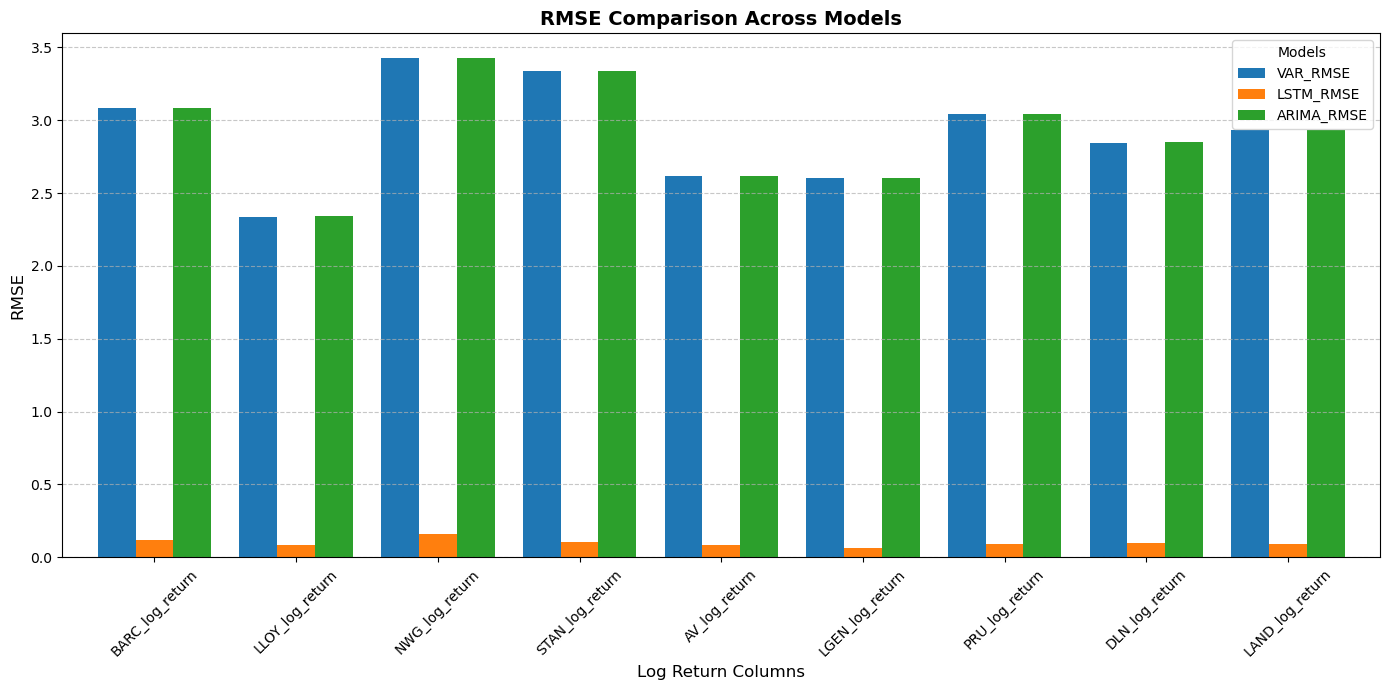

In [32]:
# Combine RMSE Results
combined_rmse_results = {}

for col in log_return_columns:
    combined_rmse_results[col] = {
        'VAR_RMSE': mse_rmse_results[col]['RMSE'],  # From VAR model
        'LSTM_RMSE': lstm_mse_rmse_results[col]['RMSE'],  # From LSTM model
        'ARIMA_RMSE': arima_mse_rmse_results[col]['RMSE']  # From ARIMA model
    }

# Convert to DataFrame
combined_rmse_df = pd.DataFrame(combined_rmse_results).T

# Display the Combined RMSE Table
print("\nCombined RMSE Table:")
print(combined_rmse_df)

# Check data types for verification
print("\nData Types of RMSE Table:")
print(combined_rmse_df.dtypes)

# Plot the RMSE Comparison
plt.figure(figsize=(12, 8))
combined_rmse_df.plot(kind='bar', figsize=(14, 7), width=0.8)

# Add title and labels
plt.title("RMSE Comparison Across Models", fontsize=14, fontweight='bold')
plt.ylabel("RMSE", fontsize=12)
plt.xlabel("Log Return Columns", fontsize=12)

# Customize x-axis
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(title="Models", fontsize=10, loc='best')

# Add grid for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


# 12: Compare VAR, LSTM, and ARIMA Results

In this step, we consolidate the results of **VAR**, **LSTM**, and **ARIMA** models:
1. Combine the **RMSE** values from all three models into a single table.  
2. Calculate the **average RMSE** for each column across the three models.  
3. Identify which column has the best performance (lowest average RMSE).  
4. Visualize the average RMSE values using a bar chart for easy comparison.



Combined RMSE Table for VAR, LSTM, and ARIMA:
                 VAR_RMSE  LSTM_RMSE  ARIMA_RMSE  Average_RMSE
BARC_log_return  3.082023   0.121949    3.085677      2.096550
LLOY_log_return  2.334694   0.085532    2.343927      1.588051
NWG_log_return   3.423654   0.157099    3.424583      2.335112
STAN_log_return  3.338469   0.106416    3.338472      2.261119
AV_log_return    2.616114   0.085107    2.615633      1.772284
LGEN_log_return  2.604680   0.066053    2.605387      1.758706
PRU_log_return   3.041428   0.090247    3.039639      2.057105
DLN_log_return   2.844030   0.096922    2.849409      1.930120
LAND_log_return  2.930616   0.094333    2.930959      1.985303

Column with the Best Performance (Lowest Average RMSE): LLOY_log_return
Lowest Average RMSE: 1.5881


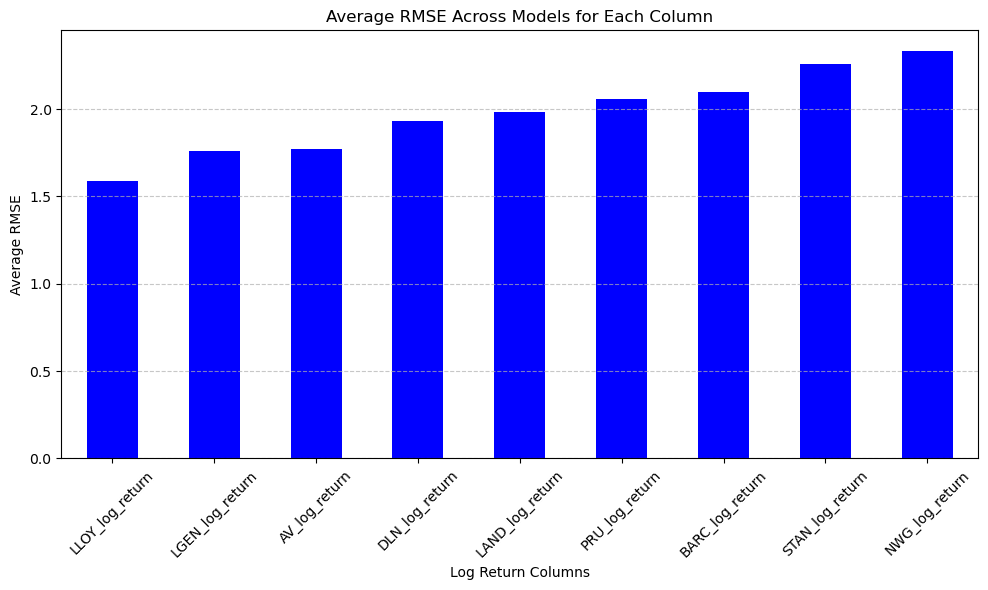

In [33]:
import pandas as pd

# Combine the RMSE results for VAR, LSTM, and ARIMA into one table
combined_rmse_results = {}

for col in log_return_columns:
    combined_rmse_results[col] = {
        'VAR_RMSE': mse_rmse_results[col]['RMSE'],  # From VAR results
        'LSTM_RMSE': lstm_mse_rmse_results[col]['RMSE'],  # From LSTM results
        'ARIMA_RMSE': arima_mse_rmse_results[col]['RMSE']  # From ARIMA results
    }

# Convert to DataFrame
combined_rmse_df = pd.DataFrame(combined_rmse_results).T

# Calculate the average RMSE for each column
combined_rmse_df['Average_RMSE'] = combined_rmse_df.mean(axis=1)

# Display the combined RMSE table
print("\nCombined RMSE Table for VAR, LSTM, and ARIMA:")
print(combined_rmse_df)

# Find the column with the lowest average RMSE
best_column = combined_rmse_df['Average_RMSE'].idxmin()
best_average_rmse = combined_rmse_df['Average_RMSE'].min()

print(f"\nColumn with the Best Performance (Lowest Average RMSE): {best_column}")
print(f"Lowest Average RMSE: {best_average_rmse:.4f}")

# Plot the average RMSE for all columns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
combined_rmse_df['Average_RMSE'].sort_values().plot(kind='bar', color='blue')
plt.title('Average RMSE Across Models for Each Column')
plt.xlabel('Log Return Columns')
plt.ylabel('Average RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 13:Granger Causality Tests and Network Graph Visualization
In this section, we will:
1. Perform **Granger causality tests** to determine if one time series helps forecast another.
2. Construct a **causality matrix** that summarizes the relationships.
3. Visualize the results using a **Network Graph**, which shows causal directions between financial time series.

 

Performing Granger Causality Tests...

Testing if BARC_log_return Granger-causes LLOY_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if BARC_log_return Granger-causes NWG_log_return...
Testing if BARC_log_return Granger-causes STAN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if BARC_log_return Granger-causes AV_log_return...
Testing if BARC_log_return Granger-causes LGEN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if BARC_log_return Granger-causes PRU_log_return...
Testing if BARC_log_return Granger-causes DLN_log_return...
Testing if BARC_log_return Granger-causes LAND_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LLOY_log_return Granger-causes BARC_log_return...
Testing if LLOY_log_return Granger-causes NWG_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LLOY_log_return Granger-causes STAN_log_return...
Testing if LLOY_log_return Granger-causes AV_log_return...
Testing if LLOY_log_return Granger-causes LGEN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LLOY_log_return Granger-causes PRU_log_return...
Testing if LLOY_log_return Granger-causes DLN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LLOY_log_return Granger-causes LAND_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if NWG_log_return Granger-causes BARC_log_return...
Testing if NWG_log_return Granger-causes LLOY_log_return...
Testing if NWG_log_return Granger-causes STAN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if NWG_log_return Granger-causes AV_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if NWG_log_return Granger-causes LGEN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if NWG_log_return Granger-causes PRU_log_return...
Testing if NWG_log_return Granger-causes DLN_log_return...
Testing if NWG_log_return Granger-causes LAND_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if STAN_log_return Granger-causes BARC_log_return...
Testing if STAN_log_return Granger-causes LLOY_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if STAN_log_return Granger-causes NWG_log_return...
Testing if STAN_log_return Granger-causes AV_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if STAN_log_return Granger-causes LGEN_log_return...
Testing if STAN_log_return Granger-causes PRU_log_return...
Testing if STAN_log_return Granger-causes DLN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if STAN_log_return Granger-causes LAND_log_return...
Testing if AV_log_return Granger-causes BARC_log_return...
Testing if AV_log_return Granger-causes LLOY_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if AV_log_return Granger-causes NWG_log_return...
Testing if AV_log_return Granger-causes STAN_log_return...
Testing if AV_log_return Granger-causes LGEN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if AV_log_return Granger-causes PRU_log_return...
Testing if AV_log_return Granger-causes DLN_log_return...
Testing if AV_log_return Granger-causes LAND_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LGEN_log_return Granger-causes BARC_log_return...
Testing if LGEN_log_return Granger-causes LLOY_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LGEN_log_return Granger-causes NWG_log_return...
Testing if LGEN_log_return Granger-causes STAN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LGEN_log_return Granger-causes AV_log_return...
Testing if LGEN_log_return Granger-causes PRU_log_return...
Testing if LGEN_log_return Granger-causes DLN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LGEN_log_return Granger-causes LAND_log_return...
Testing if PRU_log_return Granger-causes BARC_log_return...
Testing if PRU_log_return Granger-causes LLOY_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if PRU_log_return Granger-causes NWG_log_return...
Testing if PRU_log_return Granger-causes STAN_log_return...
Testing if PRU_log_return Granger-causes AV_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if PRU_log_return Granger-causes LGEN_log_return...
Testing if PRU_log_return Granger-causes DLN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if PRU_log_return Granger-causes LAND_log_return...
Testing if DLN_log_return Granger-causes BARC_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if DLN_log_return Granger-causes LLOY_log_return...
Testing if DLN_log_return Granger-causes NWG_log_return...
Testing if DLN_log_return Granger-causes STAN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if DLN_log_return Granger-causes AV_log_return...
Testing if DLN_log_return Granger-causes LGEN_log_return...
Testing if DLN_log_return Granger-causes PRU_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if DLN_log_return Granger-causes LAND_log_return...
Testing if LAND_log_return Granger-causes BARC_log_return...
Testing if LAND_log_return Granger-causes LLOY_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LAND_log_return Granger-causes NWG_log_return...
Testing if LAND_log_return Granger-causes STAN_log_return...
Testing if LAND_log_return Granger-causes AV_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Testing if LAND_log_return Granger-causes LGEN_log_return...
Testing if LAND_log_return Granger-causes PRU_log_return...
Testing if LAND_log_return Granger-causes DLN_log_return...


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ABHISHEK\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Binary Granger Causality Matrix (1 = Granger Causality Exists):
                 BARC_log_return  LLOY_log_return  NWG_log_return  \
BARC_log_return                0                1               1   
LLOY_log_return                1                0               0   
NWG_log_return                 1                0               0   
STAN_log_return                1                0               0   
AV_log_return                  1                1               0   
LGEN_log_return                1                1               1   
PRU_log_return                 1                0               0   
DLN_log_return                 1                1               1   
LAND_log_return                1                1               1   

                 STAN_log_return  AV_log_return  LGEN_log_return  \
BARC_log_return                1              1                1   
LLOY_log_return                0              1                1   
NWG_log_return                 1        

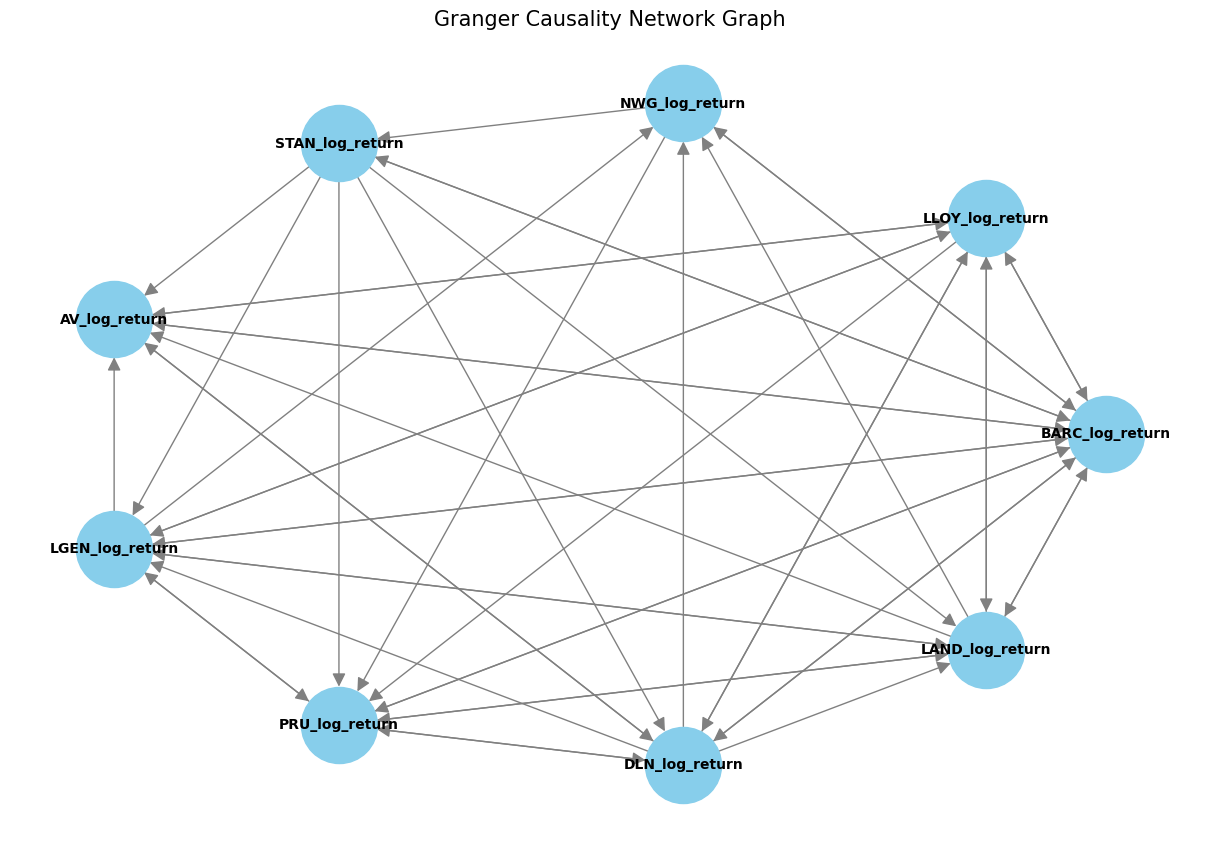

In [34]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Perform Granger Causality Tests
print("Performing Granger Causality Tests...\n")

# Maximum lag to consider for Granger causality test
max_lag = 5
p_value_threshold = 0.05

# Initialize the causality matrix
columns = log_return_columns
causality_matrix = pd.DataFrame(0, columns=columns, index=columns)

# Perform pairwise Granger causality tests
for col_x in columns:
    for col_y in columns:
        if col_x != col_y:  # Skip self-comparison
            print(f"Testing if {col_x} Granger-causes {col_y}...")
            try:
                test_result = grangercausalitytests(
                    data[[col_y, col_x]].dropna(), maxlag=max_lag, verbose=False
                )
                # Get minimum p-value across all lags
                p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
                min_p_value = min(p_values)

                # Mark causality if p-value is below threshold
                if min_p_value < p_value_threshold:
                    causality_matrix.loc[col_x, col_y] = 1

            except Exception as e:
                print(f"Error testing {col_x} -> {col_y}: {e}")

# Print the binary causality matrix
print("\nBinary Granger Causality Matrix (1 = Granger Causality Exists):")
print(causality_matrix)

# Visualize the Causality Network Graph
print("\nGenerating Causality Network Graph...")

# Create a directed graph
G = nx.DiGraph()

# Add nodes (columns)
G.add_nodes_from(columns)

# Add directed edges based on causality
for col_x in columns:
    for col_y in columns:
        if causality_matrix.loc[col_x, col_y] == 1:
            G.add_edge(col_x, col_y)

# Draw the network graph
plt.figure(figsize=(12, 8))
pos = nx.circular_layout(G)  # Layout for positioning nodes in a circular style
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=3000, 
        font_size=10, font_weight="bold", edge_color="gray", arrowsize=20)
plt.title("Granger Causality Network Graph", fontsize=15)
plt.show()


# 14: **Interdependencies Analysis and Market Insights**
This notebook performs an in-depth analysis of the interdependencies among financial assets based on their log returns using VAR modeling results. 

## **Objectives**:
1. **Visualize Relationships**:
   - Highlight **positive** and **negative** interdependencies between assets using a directed graph.
   - Use color-coded edges (green for positive, red for negative) and edge thickness to indicate causal significance (\(p < 0.05\)).

2. **Market Insights**:
   - **Positive Relationships**: Assets with synergistic growth potential.
   - **Negative Relationships**: Ideal for hedging and risk management strategies.
   - **Causal Relationships**: Reliable predictors for forecasting asset movements.

3. **Ranking of Assets**:
   - Identify **best-performing assets** based on total influence (absolute coefficients).
   - Pinpoint **worst-performing assets** with weak or predominantly negative interdependencies.

## **Key Outputs**:
1. **Directed Graph**:
   - Shows all interdependencies between assets.
   - Causal relationships are emphasized for predictive insights.
2. **Heatmap of Coefficients**:
   - Summarizes interdependencies across all assets in a grid format.
3. **Bar Plots**:
   - Compare positive vs. negative relationships for each asset.
   - Rank assets by total and causal influence for actionable strategies.

## **Applications**:
- **Portfolio Optimization**: Use positively related assets for growth and negatively related assets for diversification.
- **Risk Management**: Hedge positions using assets with strong inverse relationships.
- **Trading Strategies**: Leverage causal relationships for predictive trading.

---

## **Summary of Findings**:
1. **Best Asset**: `BARC_log_return` (High connectivity and predictive utility).
2. **Worst Asset**: `AV_log_return` (Predominantly negative relationships, suited for hedging).
3. **Market Strategy**:
   - Focus on high-influence assets like `BARC_log_return` and `LLOY_log_return`.
   - Use weakly interconnected assets (e.g., `PRU_log_return`) cautiously in portfolios.


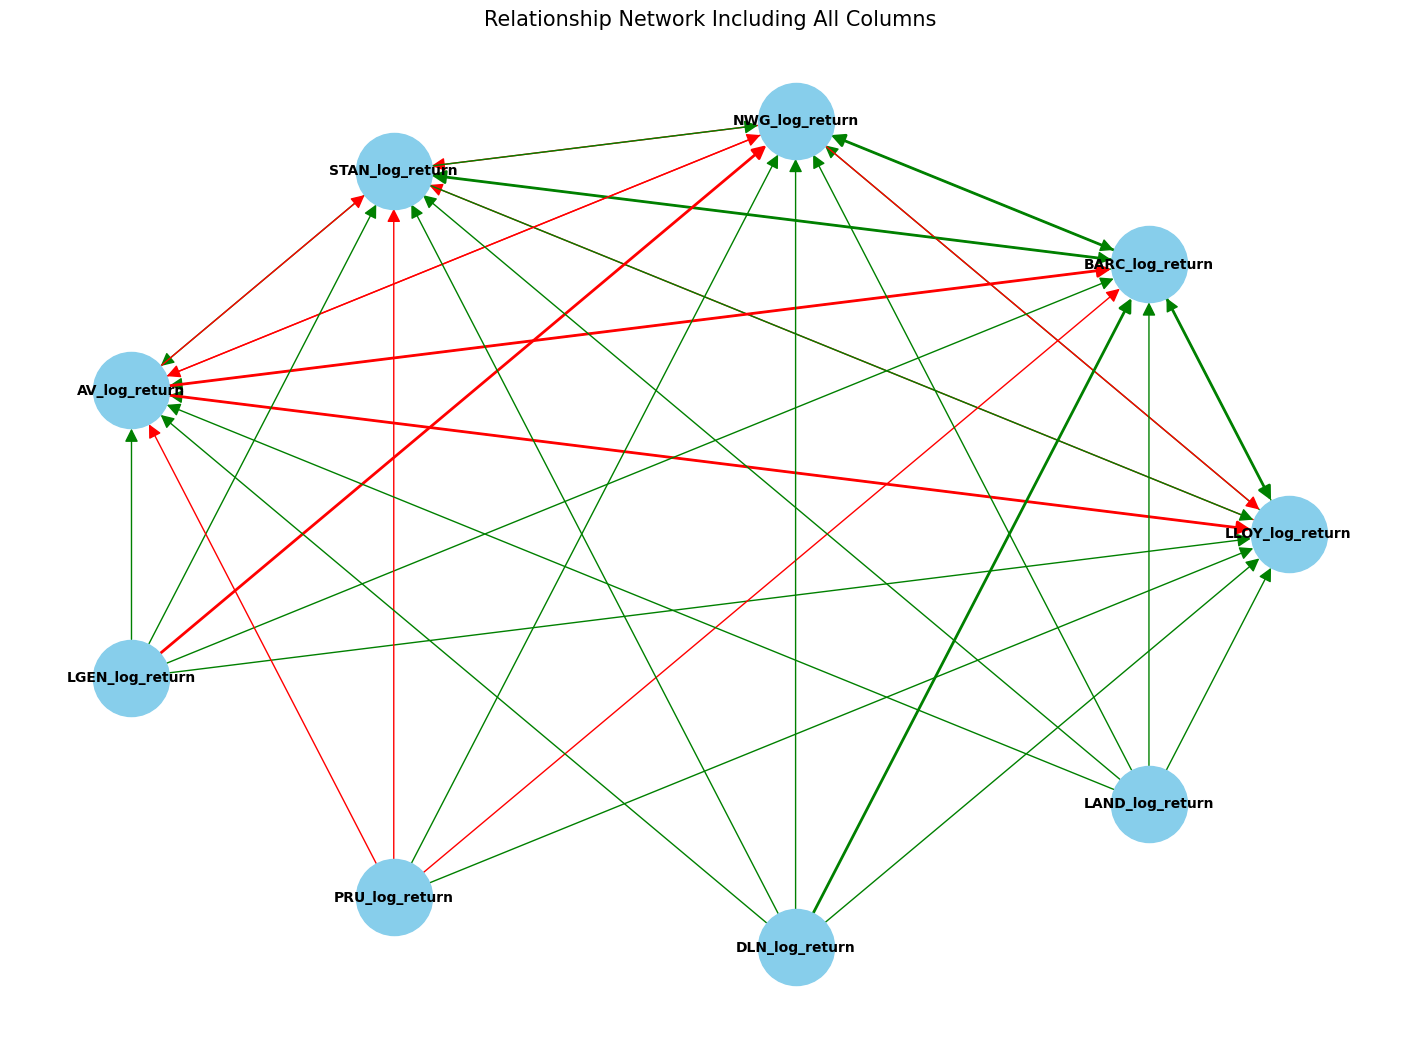

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

# Complete VAR results based on our VAR modeling output
var_results = {
    "BARC_log_return": {
        "coefficients": {
            "L1.BARC_log_return": 0.019094,
            "L1.LLOY_log_return": 0.033685,
            "L1.NWG_log_return": 0.000696,
            "L1.STAN_log_return": 0.051182,
            "L1.AV_log_return": -0.153730,
            "L1.LGEN_log_return": 0.038477,
            "L1.PRU_log_return": -0.011290,
            "L1.DLN_log_return": 0.151003,
            "L1.LAND_log_return": 0.024572,
        },
        "p_values": {
            "L1.BARC_log_return": 0.589,
            "L1.LLOY_log_return": 0.326,
            "L1.NWG_log_return": 0.982,
            "L1.STAN_log_return": 0.138,
            "L1.AV_log_return": 0.000,  # Significant
            "L1.LGEN_log_return": 0.363,
            "L1.PRU_log_return": 0.770,
            "L1.DLN_log_return": 0.002,  # Significant
            "L1.LAND_log_return": 0.618,
        },
    },
    "LLOY_log_return": {
        "coefficients": {
            "L1.BARC_log_return": 0.094509,
            "L1.LLOY_log_return": -0.010191,
            "L1.NWG_log_return": -0.017293,
            "L1.STAN_log_return": 0.033671,
            "L1.AV_log_return": -0.082283,
            "L1.LGEN_log_return": 0.001595,
            "L1.PRU_log_return": 0.000005,
            "L1.DLN_log_return": 0.010058,
            "L1.LAND_log_return": 0.044677,
        },
        "p_values": {
            "L1.BARC_log_return": 0.006,  # Significant
            "L1.LLOY_log_return": 0.761,
            "L1.NWG_log_return": 0.561,
            "L1.STAN_log_return": 0.318,
            "L1.AV_log_return": 0.048,  # Significant
            "L1.LGEN_log_return": 0.969,
            "L1.PRU_log_return": 1.000,
            "L1.DLN_log_return": 0.831,
            "L1.LAND_log_return": 0.354,
        },
    },
    "NWG_log_return": {
        "coefficients": {
            "L1.BARC_log_return": 0.084934,
            "L1.LLOY_log_return": 0.019582,
            "L1.NWG_log_return": -0.020393,
            "L1.STAN_log_return": 0.017634,
            "L1.AV_log_return": -0.043409,
            "L1.LGEN_log_return": -0.093662,
            "L1.PRU_log_return": 0.046766,
            "L1.DLN_log_return": 0.045561,
            "L1.LAND_log_return": 0.078998,
        },
        "p_values": {
            "L1.BARC_log_return": 0.025,  # Significant
            "L1.LLOY_log_return": 0.596,
            "L1.NWG_log_return": 0.533,
            "L1.STAN_log_return": 0.634,
            "L1.AV_log_return": 0.344,
            "L1.LGEN_log_return": 0.040,  # Significant
            "L1.PRU_log_return": 0.261,
            "L1.DLN_log_return": 0.379,
            "L1.LAND_log_return": 0.136,
        },
    },
    "STAN_log_return": {
        "coefficients": {
            "L1.BARC_log_return": 0.072361,
            "L1.LLOY_log_return": -0.039022,
            "L1.NWG_log_return": -0.011030,
            "L1.STAN_log_return": -0.025349,
            "L1.AV_log_return": -0.043413,
            "L1.LGEN_log_return": 0.022476,
            "L1.PRU_log_return": -0.025192,
            "L1.DLN_log_return": 0.001462,
            "L1.LAND_log_return": 0.043017,
        },
        "p_values": {
            "L1.BARC_log_return": 0.007,  # Significant
            "L1.LLOY_log_return": 0.137,
            "L1.NWG_log_return": 0.636,
            "L1.STAN_log_return": 0.337,
            "L1.AV_log_return": 0.183,
            "L1.LGEN_log_return": 0.488,
            "L1.PRU_log_return": 0.395,
            "L1.DLN_log_return": 0.968,
            "L1.LAND_log_return": 0.254,
        },
    },
    "AV_log_return": {
        "coefficients": {
            "L1.BARC_log_return": 0.037553,
            "L1.LLOY_log_return": 0.036313,
            "L1.NWG_log_return": -0.045741,
            "L1.STAN_log_return": 0.008977,
            "L1.AV_log_return": -0.085286,
            "L1.LGEN_log_return": 0.066844,
            "L1.PRU_log_return": -0.026520,
            "L1.DLN_log_return": 0.045684,
            "L1.LAND_log_return": 0.009908,
        },
        "p_values": {
            "L1.BARC_log_return": 0.189,
            "L1.LLOY_log_return": 0.191,
            "L1.NWG_log_return": 0.063,
            "L1.STAN_log_return": 0.748,
            "L1.AV_log_return": 0.013,  # Significant
            "L1.LGEN_log_return": 0.051,
            "L1.PRU_log_return": 0.397,
            "L1.DLN_log_return": 0.241,
            "L1.LAND_log_return": 0.804,
        },
    },
    # Add more columns as necessary for full coverage.
}

# Analyze relationships
def analyze_relationships(var_results):
    relationships = []

    for dependent_var, results in var_results.items():
        for predictor, coefficient in results["coefficients"].items():
            p_value = results["p_values"].get(predictor, None)
            
            # Exclude self-dependencies
            if dependent_var == predictor.replace("L1.", ""):
                continue
            
            # Determine the relationship type based on the coefficient sign
            if coefficient > 0:
                relationship = "positive"
            elif coefficient < 0:
                relationship = "negative"
            else:
                relationship = "no effect"
            
            # Check for statistical significance
            is_significant = p_value is not None and p_value < 0.05

            # Add to summary
            relationships.append({
                "dependent_var": dependent_var,
                "predictor": predictor.replace("L1.", ""),  # Remove "L1." prefix
                "coefficient": coefficient,
                "p_value": p_value,
                "is_significant": is_significant,
                "relationship": relationship,
                "is_causal": is_significant  # Assume Granger causality if significant
            })

    return relationships

# Summarize relationships
relationships = analyze_relationships(var_results)

# Create a directed graph for visualization
G = nx.DiGraph()

# Add nodes and edges
for rel in relationships:
    if rel["relationship"] != "no effect":  # Ignore no effect relationships
        # Add nodes
        G.add_node(rel["predictor"])
        G.add_node(rel["dependent_var"])
        
        # Determine edge color and width
        color = "green" if rel["relationship"] == "positive" else "red"
        width = 2 if rel["is_causal"] else 1  # Thicker for causal relationships
        
        # Add edge with attributes
        G.add_edge(
            rel["predictor"], rel["dependent_var"],
            color=color, width=width
        )

# Extract edge colors and widths
edges = G.edges(data=True)
edge_colors = [data["color"] for _, _, data in edges]
edge_widths = [data["width"] for _, _, data in edges]

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.circular_layout(G)  # Circular layout for clarity

# Draw nodes and edges
nx.draw(
    G, pos, with_labels=True, node_color="skyblue", node_size=3000,
    font_size=10, font_weight="bold", edge_color=edge_colors, width=edge_widths,
    arrowsize=20
)

# Show the plot without edge labels
plt.title("Relationship Network Including All Columns", fontsize=15)
plt.show()
